In [1]:
# # ==========================================
# # FINAL SUMMARY
# # ==========================================
# print("\n" + "="*80)
# print("PROJECT SUMMARY - MODEL TRAINING & EVALUATION")
# print("="*80)

# print("\n📊 Data Preparation:")
# print(f"  • Original data: {len(X_full)} samples")
# print(f"  • Train set: {len(y_train)} samples (60%) - For focal loss training")
# print(f"  • Val set: {len(y_val)} samples (20%) - For focal loss validation")
# print(f"  • Train+Val set: {len(y_trainval)} samples (80%) - For regular models")
# print(f"  • Test set: {len(y_test)} samples (20%) - Final evaluation")
# print(f"  • Features after engineering: {X_train_transformed.shape[1]}")
# print(f"  • Features after selection: {X_train_selected.shape[1]}")

# print("\n🤖 Baseline Models Trained:")
# models_list = [name for name in results_dict.keys() if '(Tuned)' not in name]
# for i, model_name in enumerate(models_list, 1):
#     pr_auc = results_dict[model_name]['pr_auc']
#     roc_auc = results_dict[model_name]['roc_auc']
#     print(f"  {i}. {model_name:30s} - PR AUC: {pr_auc:.4f}, ROC AUC: {roc_auc:.4f}")

# print(f"\n🏆 Best Baseline Model: {best_model_name}")
# print(f"  • PR AUC: {comparison_df.loc[best_model_name, 'pr_auc']:.4f}")
# print(f"  • ROC AUC: {comparison_df.loc[best_model_name, 'roc_auc']:.4f}")
# print(f"  • F1 Score: {comparison_df.loc[best_model_name, 'f1']:.4f}")

# if f"{best_model_name} (Tuned)" in results_dict:
#     print(f"\n⚙️ After Hyperparameter Tuning:")
#     print(f"  • PR AUC: {results_dict[f'{best_model_name} (Tuned)']['pr_auc']:.4f}")
#     print(f"  • ROC AUC: {results_dict[f'{best_model_name} (Tuned)']['roc_auc']:.4f}")
#     print(f"  • F1 Score: {results_dict[f'{best_model_name} (Tuned)']['f1']:.4f}")
#     improvement = results_dict[f'{best_model_name} (Tuned)']['pr_auc'] - comparison_df.loc[best_model_name, 'pr_auc']
#     print(f"  • Improvement: +{improvement:.4f}")

# print("\n💾 Saved Files:")
# print("  • models/logistic_regression.pkl")
# print("  • models/random_forest.pkl")
# print("  • models/xgboost.pkl")
# print("  • models/lightgbm.pkl")
# print("  • models/xgboost_focal_loss.pkl")
# print("  • models/lightgbm_focal_loss.pkl")
# if best_params is not None:
#     print("  • models/final_best_model.pkl")
#     print("  • models/best_hyperparams.json")
# print("  • models/baseline_comparison.csv")
# print("  • models/baseline_comparison.png")
# print("  • feature_selector.pkl")
# print("  • standard_scaler.pkl")
# print("  • selected_features_info.csv")

# print("\n" + "="*80)
# print("✅ MODEL TRAINING & EVALUATION COMPLETED SUCCESSFULLY!")
# print("="*80)

# Model Training and Evaluation - Home Credit Default Risk

Notebook này thực hiện training và evaluation các mô hình machine learning để dự đoán khả năng trả nợ của khách hàng.

**Nội dung chính:**
1. Load dữ liệu đã được feature engineering
2. Data preparation & feature selection
3. Model training (Logistic Regression, SVM, Random Forest, XGBoost, LightGBM)
4. Model comparison
5. Model calibration
6. Feature importance analysis

## 1. Setup & Import Libraries

In [2]:
# Data manipulation
import numpy as np
import pandas as pd
import joblib
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Import custom transformers from src folder
import sys
import importlib
sys.path.insert(0, 'c:\\Users\\SonNT\\Downloads\\Internship2')

# Reload module to get latest changes
import src.transformers as transformers_module
importlib.reload(transformers_module)

from src.transformers import (
    NullOutlierFixer,
    ApplicationFeatureEngineer,
    BureauFeatureEngineer,
    PreviousApplicationFeatureEngineer,
    POSCashFeatureEngineer,
    InstallmentsPaymentsFeatureEngineer,
    CreditCardBalanceFeatureEngineer,
    create_feature_engineering_pipeline
)

from src.model_utils import (
    calculate_all_metrics,
    print_metrics,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_confusion_matrix,
    save_model_results
)

# Import focal loss functions
from src.focal_loss import (
    create_focal_loss_lgb,
    create_focal_loss_lgb_eval,
    create_focal_loss_xgb,
    create_focal_loss_xgb_eval
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb

# Machine Learning - Metrics
from sklearn.metrics import (
    roc_auc_score, average_precision_score, 
    f1_score, precision_score, recall_score, 
    accuracy_score, brier_score_loss,
    roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Hyperopt for hyperparameter tuning
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Create models directory if not exists
os.makedirs('models', exist_ok=True)

print("✓ All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ All libraries imported successfully!
NumPy version: 2.3.5
Pandas version: 2.3.3


## 2. Load Data and Train/Val/Test Split

**⚠️ QUAN TRỌNG: Chia data TRƯỚC KHI fit pipeline để tránh data leakage!**

Workflow:
1. Load application_train.csv (data gốc với labels)
2. **Split 1: Chia thành (train+val) / test (80%/20%) - Random split (không stratified)**
3. **Split 2: Chia train+val thành train / val (75%/25% = 60%/20% của total) - Stratified split**
4. Fit pipeline CHỈ trên train set
5. Transform train/val/test với fitted pipeline

**Lưu ý về training:**
- Models không dùng focal loss: Train trên full tập (train+val) = 80% data
- Models dùng focal loss: Train trên train (60%), validate trên val (20%)
- Tất cả models: Đánh giá cuối trên test (20%)

In [3]:
# Load dữ liệu gốc (chỉ dùng application_train.csv có labels)
print("Loading original data...")
data = pd.read_csv('home-credit-default-risk/application_train.csv')

print(f"Original data shape: {data.shape}")
print(f"\nTarget distribution:")
print(data['TARGET'].value_counts())
print(f"Class imbalance ratio: {data['TARGET'].value_counts()[0]/data['TARGET'].value_counts()[1]:.2f}:1")

Loading original data...
Original data shape: (307511, 122)

Target distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64
Class imbalance ratio: 11.39:1


In [4]:
# Tách target (GIỮ SK_ID_CURR cho pipeline - cần để merge các bảng phụ)
y_full = data['TARGET'].copy()
X_full = data.drop(['TARGET'], axis=1)  # Giữ SK_ID_CURR cho pipeline

print(f"X_full shape: {X_full.shape}")
print(f"y_full shape: {y_full.shape}")
print(f"Features (including SK_ID_CURR): {X_full.shape[1]}")
print("\n⚠️ Note: SK_ID_CURR will be dropped AFTER feature engineering")

X_full shape: (307511, 121)
y_full shape: (307511,)
Features (including SK_ID_CURR): 121

⚠️ Note: SK_ID_CURR will be dropped AFTER feature engineering


In [5]:
# ==========================================
# BƯỚC 1: CHIA TRAIN/VAL/TEST
# ==========================================
print("\n" + "="*80)
print("STEP 1: SPLIT DATA INTO TRAIN/VAL/TEST")
print("="*80)

# Split 1: Chia (train+val) / test = 80/20 - RANDOM (không stratified)
print("\n[Split 1] Splitting into (train+val) / test (80/20) - Random split")
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True  # Random shuffle, không stratified
)

# Split 2: Chia train+val thành train / val = 75/25 - STRATIFIED (cho focal loss models)
print("[Split 2] Splitting train+val into train / val (75/25) - Stratified split")
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of total
    stratify=y_trainval,  # Stratified để cân bằng cho focal loss
    random_state=RANDOM_STATE
)

print("\n" + "="*60)
print("Data Split Summary:")
print("="*60)
print(f"Train set:      {X_train.shape[0]:>7} samples ({X_train.shape[0]/len(X_full)*100:.1f}%) - For focal loss training")
print(f"Val set:        {X_val.shape[0]:>7} samples ({X_val.shape[0]/len(X_full)*100:.1f}%) - For focal loss validation")
print(f"Train+Val set:  {X_trainval.shape[0]:>7} samples ({X_trainval.shape[0]/len(X_full)*100:.1f}%) - For regular models")
print(f"Test set:       {X_test.shape[0]:>7} samples ({X_test.shape[0]/len(X_full)*100:.1f}%) - Final evaluation")
print(f"Total:          {len(X_full):>7} samples")

print("\n" + "="*60)
print("Class Distribution:")
print("="*60)
print(f"Train:     Class 0: {(y_train==0).sum():>7} ({(y_train==0).sum()/len(y_train)*100:.2f}%), Class 1: {(y_train==1).sum():>7} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")
print(f"Val:       Class 0: {(y_val==0).sum():>7} ({(y_val==0).sum()/len(y_val)*100:.2f}%), Class 1: {(y_val==1).sum():>7} ({(y_val==1).sum()/len(y_val)*100:.2f}%)")
print(f"Train+Val: Class 0: {(y_trainval==0).sum():>7} ({(y_trainval==0).sum()/len(y_trainval)*100:.2f}%), Class 1: {(y_trainval==1).sum():>7} ({(y_trainval==1).sum()/len(y_trainval)*100:.2f}%)")
print(f"Test:      Class 0: {(y_test==0).sum():>7} ({(y_test==0).sum()/len(y_test)*100:.2f}%), Class 1: {(y_test==1).sum():>7} ({(y_test==1).sum()/len(y_test)*100:.2f}%)")
print("="*60)


STEP 1: SPLIT DATA INTO TRAIN/VAL/TEST

[Split 1] Splitting into (train+val) / test (80/20) - Random split
[Split 2] Splitting train+val into train / val (75/25) - Stratified split

Data Split Summary:
Train set:       184506 samples (60.0%) - For focal loss training
Val set:          61502 samples (20.0%) - For focal loss validation
Train+Val set:   246008 samples (80.0%) - For regular models
Test set:         61503 samples (20.0%) - Final evaluation
Total:           307511 samples

Class Distribution:
Train:     Class 0:  169599 (91.92%), Class 1:   14907 (8.08%)
Val:       Class 0:   56533 (91.92%), Class 1:    4969 (8.08%)
Train+Val: Class 0:  226132 (91.92%), Class 1:   19876 (8.08%)
Test:      Class 0:   56554 (91.95%), Class 1:    4949 (8.05%)


## 3. Feature Engineering Pipeline

**⚠️ FIT CHỈ TRÊN TRAIN SET - TRÁNH DATA LEAKAGE!**

Pipeline sẽ:
1. Xử lý null values và outliers
2. Tạo features từ application data
3. Aggregate features từ bureau, previous_application, POS_CASH, installments, credit_card

In [6]:
# ==========================================
# BƯỚC 2: CREATE & FIT PIPELINE (TRAIN ONLY)
# ==========================================
print("\n" + "="*80)
print("STEP 2: FEATURE ENGINEERING PIPELINE")
print("="*80)

# Create pipeline
print("\n⏳ Creating feature engineering pipeline...")
fe_pipeline = create_feature_engineering_pipeline('home-credit-default-risk')
print("✓ Pipeline created!")

# Fit pipeline CHỈ trên train set
print("\n⏳ Fitting pipeline on TRAIN SET ONLY (to avoid data leakage)...")
fe_pipeline.fit(X_train, y_train)
print("✓ Pipeline fitted on train set!")

# Save fitted pipeline
joblib.dump(fe_pipeline, 'home-credit-default-risk/feature_engineering_pipeline_fitted.pkl')
print("✓ Fitted pipeline saved to 'feature_engineering_pipeline_fitted.pkl'")


STEP 2: FEATURE ENGINEERING PIPELINE

⏳ Creating feature engineering pipeline...
✓ Pipeline created!

⏳ Fitting pipeline on TRAIN SET ONLY (to avoid data leakage)...
✓ Pipeline fitted on train set!
✓ Fitted pipeline saved to 'feature_engineering_pipeline_fitted.pkl'


In [7]:
# ==========================================
# BƯỚC 3: TRANSFORM TRAIN/VAL/TEST
# ==========================================
print("\n" + "="*80)
print("STEP 3: TRANSFORM DATA WITH FITTED PIPELINE")
print("="*80)

# Transform tất cả datasets
print("\n⏳ Transforming train set...")
X_train_transformed = fe_pipeline.transform(X_train)
print(f"✓ Train transformed: {X_train_transformed.shape}")

print("\n⏳ Transforming val set...")
X_val_transformed = fe_pipeline.transform(X_val)
print(f"✓ Val transformed: {X_val_transformed.shape}")

print("\n⏳ Transforming train+val set...")
X_trainval_transformed = fe_pipeline.transform(X_trainval)
print(f"✓ Train+Val transformed: {X_trainval_transformed.shape}")

print("\n⏳ Transforming test set...")
X_test_transformed = fe_pipeline.transform(X_test)
print(f"✓ Test transformed: {X_test_transformed.shape}")

# ==========================================
# DROP SK_ID_CURR AFTER TRANSFORMATION
# ==========================================
print("\n⏳ Dropping SK_ID_CURR column...")
if 'SK_ID_CURR' in X_train_transformed.columns:
    X_train_transformed = X_train_transformed.drop('SK_ID_CURR', axis=1)
    X_val_transformed = X_val_transformed.drop('SK_ID_CURR', axis=1)
    X_trainval_transformed = X_trainval_transformed.drop('SK_ID_CURR', axis=1)
    X_test_transformed = X_test_transformed.drop('SK_ID_CURR', axis=1)
    print("✓ SK_ID_CURR dropped from all datasets")

print("\n" + "="*80)
print("SUMMARY AFTER FEATURE ENGINEERING:")
print("="*80)
print(f"Original features:    {X_train.shape[1] - 1} (excluding SK_ID_CURR)")
print(f"Engineered features:  {X_train_transformed.shape[1]}")
print(f"Features added:       {X_train_transformed.shape[1] - (X_train.shape[1] - 1)}")
print("\nDataset shapes:")
print(f"  X_train_transformed:    {X_train_transformed.shape}")
print(f"  X_val_transformed:      {X_val_transformed.shape}")
print(f"  X_trainval_transformed: {X_trainval_transformed.shape}")
print(f"  X_test_transformed:     {X_test_transformed.shape}")


STEP 3: TRANSFORM DATA WITH FITTED PIPELINE

⏳ Transforming train set...
✓ Train transformed: (184506, 560)

⏳ Transforming val set...
✓ Val transformed: (61502, 560)

⏳ Transforming train+val set...
✓ Train+Val transformed: (246008, 560)

⏳ Transforming test set...
✓ Test transformed: (61503, 560)

⏳ Dropping SK_ID_CURR column...
✓ SK_ID_CURR dropped from all datasets

SUMMARY AFTER FEATURE ENGINEERING:
Original features:    120 (excluding SK_ID_CURR)
Engineered features:  559
Features added:       439

Dataset shapes:
  X_train_transformed:    (184506, 559)
  X_val_transformed:      (61502, 559)
  X_trainval_transformed: (246008, 559)
  X_test_transformed:     (61503, 559)


In [8]:
# ==========================================
# MEMORY OPTIMIZATION: DELETE UNUSED VARIABLES
# ==========================================
print("\n" + "="*80)
print("MEMORY OPTIMIZATION - STEP 1: After Transformation")
print("="*80)

import gc

# Check memory before cleanup
print("\n📊 Memory usage before cleanup:")
print(f"  data: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  X_full: {X_full.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  X_train (original): {X_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  X_val (original): {X_val.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  X_trainval (original): {X_trainval.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  X_test (original): {X_test.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Delete original datasets (no longer needed after transformation)
print("\n⏳ Deleting original datasets...")
del data, X_full, X_train, X_val, X_trainval, X_test
gc.collect()
print("✓ Deleted: data, X_full, X_train, X_val, X_trainval, X_test")

print("\n✅ Memory cleanup completed!")
print("="*80)


MEMORY OPTIMIZATION - STEP 1: After Transformation

📊 Memory usage before cleanup:
  data: 504.99 MB
  X_full: 502.64 MB
  X_train (original): 302.99 MB
  X_val (original): 100.98 MB
  X_trainval (original): 403.97 MB
  X_test (original): 101.01 MB

⏳ Deleting original datasets...
✓ Deleted: data, X_full, X_train, X_val, X_trainval, X_test

✅ Memory cleanup completed!


## 4. Feature Selection with SelectKBest

**⚠️ FIT CHỈ TRÊN TRAIN SET - TRANSFORM TRÊN VAL/TEST**

Chọn top K features quan trọng nhất sử dụng f_classif score

In [9]:
print("\n" + "="*80)
print("STEP 4: FEATURE SELECTION")
print("="*80)

k_best = 150 

print(f"Selected k for this analysis: {k_best}")

print(f"\nTotal features available: {X_train_transformed.shape[1]}")


STEP 4: FEATURE SELECTION
Selected k for this analysis: 150

Total features available: 559


In [10]:
# Áp dụng SelectKBest - FIT trên TRAIN ONLY
print("\n⏳ Fitting SelectKBest on train set...")
selector = SelectKBest(score_func=f_classif, k=k_best)
selector.fit(X_train_transformed, y_train)
print("✓ SelectKBest fitted on train set!")

# Lấy indices và tên của features được chọn
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train_transformed.columns[selected_feature_indices].tolist()
selected_feature_scores = selector.scores_[selected_feature_indices]

# In thông tin về features được chọn
print(f"\n📊 Selected Features Information:")
print(f"  - Total selected: {len(selected_feature_names)}")
print(f"  - Score range: [{selected_feature_scores.min():.2f}, {selected_feature_scores.max():.2f}]")

# Tạo DataFrame với thông tin features và scores
feature_selection_info = pd.DataFrame({
    'feature_name': selected_feature_names,
    'feature_index': selected_feature_indices,
    'f_score': selected_feature_scores
}).sort_values('f_score', ascending=False)

# Lưu thông tin feature selection
feature_selection_info.to_csv('selected_features_info.csv', index=False)
print(f"\n✓ Feature selection info saved to 'selected_features_info.csv'")

# Hiển thị top 20 features
print(f"\n📈 Top 20 Selected Features (by F-score):")
print(feature_selection_info.head(20).to_string(index=False))

# Transform tất cả datasets
print("\n⏳ Transforming all datasets...")
X_train_selected = pd.DataFrame(
    selector.transform(X_train_transformed),
    columns=selected_feature_names,
    index=X_train_transformed.index
)
X_val_selected = pd.DataFrame(
    selector.transform(X_val_transformed),
    columns=selected_feature_names,
    index=X_val_transformed.index
)
X_trainval_selected = pd.DataFrame(
    selector.transform(X_trainval_transformed),
    columns=selected_feature_names,
    index=X_trainval_transformed.index
)
X_test_selected = pd.DataFrame(
    selector.transform(X_test_transformed),
    columns=selected_feature_names,
    index=X_test_transformed.index
)

print(f"\n✓ Feature selection completed!")
print(f"Features after selection: {X_train_selected.shape[1]}")
print(f"\nDataset shapes after feature selection:")
print(f"  X_train_selected:    {X_train_selected.shape}")
print(f"  X_val_selected:      {X_val_selected.shape}")
print(f"  X_trainval_selected: {X_trainval_selected.shape}")
print(f"  X_test_selected:     {X_test_selected.shape}")

# Lưu feature selector và feature names
joblib.dump(selector, 'feature_selector.pkl')
joblib.dump(selected_feature_names, 'selected_feature_names.pkl')
print("\n✓ Feature selector saved to 'feature_selector.pkl'")
print("✓ Selected feature names saved to 'selected_feature_names.pkl'")


⏳ Fitting SelectKBest on train set...
✓ SelectKBest fitted on train set!

📊 Selected Features Information:
  - Total selected: 150
  - Score range: [139.06, 4754.15]

✓ Feature selection info saved to 'selected_features_info.csv'

📈 Top 20 Selected Features (by F-score):
                        feature_name  feature_index     f_score
                        EXT_SOURCE_2             28 4754.150602
                        EXT_SOURCE_3             29 2722.444114
             BUREAU_DAYS_CREDIT_MEAN            256 1294.325076
                          DAYS_BIRTH              6 1166.579157
           C_BUREAU_DAYS_CREDIT_MEAN            304  935.088599
      BUREAU_DAYS_CREDIT_UPDATE_MEAN            258  934.281425
                       DAYS_EMPLOYED              7  760.465502
    CR_CNT_DRAWINGS_ATM_CURRENT_MEAN            516  753.697873
                        EXT_SOURCE_1             27  732.991999
         REGION_RATING_CLIENT_W_CITY             19  710.962501
                      I

In [11]:
X_train_selected

,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,...,CR_CNT_DRAWINGS_ATM_CURRENT_MEAN,CR_CNT_DRAWINGS_ATM_CURRENT_SUM,CR_CNT_DRAWINGS_ATM_CURRENT_VAR,CR_CNT_DRAWINGS_CURRENT_MAX,CR_CNT_DRAWINGS_CURRENT_MEAN,CR_CNT_DRAWINGS_CURRENT_SUM,CR_CNT_DRAWINGS_CURRENT_VAR,CR_CNT_DRAWINGS_POS_CURRENT_MAX,CR_CNT_DRAWINGS_POS_CURRENT_MEAN,CR_CNT_DRAWINGS_POS_CURRENT_VAR
0,490536.0,405000.0,0.022625,-11442.0,-1430.0,-4912.0,-3365.0,1.0,0.0,2.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000
1,1143000.0,1143000.0,0.018209,-18743.0,-3520.0,-5118.0,-2256.0,1.0,1.0,3.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000
2,270000.0,270000.0,0.025164,-11239.0,-1584.0,-393.0,-3841.0,1.0,0.0,2.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000
3,62361.0,58500.0,0.020246,-19430.0,-1646.0,-8223.0,-2951.0,0.0,0.0,3.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000
4,332473.5,274500.0,0.018634,-16873.0,-2078.0,-4014.0,-423.0,1.0,0.0,2.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184501,803259.0,670500.0,0.020713,-16267.0,-2361.0,-10358.0,-3986.0,1.0,0.0,3.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000
184502,521280.0,450000.0,0.004960,-19845.0,-1646.0,-4605.0,-147.0,0.0,0.0,2.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000
184503,270000.0,270000.0,0.018634,-11398.0,-2102.0,-942.0,-3297.0,1.0,0.0,2.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000
184504,180000.0,180000.0,0.026392,-17475.0,-146.0,-5734.0,-1002.0,1.0,0.0,2.0,...,0.074074,2.0,0.148148,2.0,0.333333,9.0,0.307692,1.0,0.259259,0.19943


## 5. Standardization with StandardScaler

**⚠️ FIT CHỈ TRÊN TRAIN SET - TRANSFORM TRÊN TẤT CẢ DATASETS**

Chuẩn hóa features về cùng scale (mean=0, std=1)

In [12]:
print("\n" + "="*80)
print("STEP 5: STANDARDIZATION")
print("="*80)

# Khởi tạo StandardScaler
print("\n⏳ Fitting StandardScaler on train set...")
scaler = StandardScaler()
scaler.fit(X_train_selected)
print("✓ StandardScaler fitted on train set!")

# Transform tất cả datasets
print("\n⏳ Transforming all datasets...")
X_train_scaled = scaler.transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)
X_trainval_scaled = scaler.transform(X_trainval_selected)
X_test_scaled = scaler.transform(X_test_selected)

print("\n✓ Standardization completed!")
print(f"\nTrain data statistics after scaling:")
print(f"  Mean: {X_train_scaled.mean():.6f}")
print(f"  Std:  {X_train_scaled.std():.6f}")
print("\n" + "="*80)

# Lưu scaler
joblib.dump(scaler, 'standard_scaler.pkl')
print("\n✓ Scaler saved to 'standard_scaler.pkl'")


STEP 5: STANDARDIZATION

⏳ Fitting StandardScaler on train set...
✓ StandardScaler fitted on train set!

⏳ Transforming all datasets...

✓ Standardization completed!

Train data statistics after scaling:
  Mean: 0.000000
  Std:  1.000000


✓ Scaler saved to 'standard_scaler.pkl'


## 7. Model Training & Evaluation

### Chiến lược Training:
1. **Baseline Models** (không focal loss): Train trên train+val (80% data), đánh giá trên test (20%)
   - Logistic Regression
   - Random Forest
   - XGBoost (standard)
   - LightGBM (standard)

2. **Focal Loss Models**: Train trên train (60%), validate trên val (20%), đánh giá trên test (20%)
   - XGBoost + Focal Loss
   - LightGBM + Focal Loss

3. **Model tốt nhất** sẽ được chọn để hyperparameter tuning với Hyperopt

### 7.1 Setup cho Training

In [13]:
# Dictionary để lưu kết quả của tất cả models
results_dict = {}

print("="*80)
print("STARTING MODEL TRAINING PIPELINE")
print("="*80)
print("\n📋 Training Strategy:")
print("  • Baseline models (LR, RF, XGB, LGB): Train on train (60%), evaluate on val (20%)")
print("  • Hyperparameter tuning: Optimize on val set (no cross-validation)")
print("  • Final tuned model: Evaluate on test set (20%) after calibration")
print("="*80)

STARTING MODEL TRAINING PIPELINE

📋 Training Strategy:
  • Baseline models (LR, RF, XGB, LGB): Train on train (60%), evaluate on val (20%)
  • Hyperparameter tuning: Optimize on val set (no cross-validation)
  • Final tuned model: Evaluate on test set (20%) after calibration



7.2 LOGISTIC REGRESSION - BASELINE
Training on: train (60% of data)
Evaluation on: val (20% of data)

⏳ Training Logistic Regression...
✓ Training completed!

⏳ Generating predictions on validation set...

📊 Classification Report:
                precision    recall  f1-score   support

No Default (0)       0.96      0.69      0.80     56533
   Default (1)       0.16      0.67      0.26      4969

      accuracy                           0.69     61502
     macro avg       0.56      0.68      0.53     61502
  weighted avg       0.89      0.69      0.76     61502


               Logistic Regression - Test Set               
ROC AUC Score:     0.7444
PR AUC Score:      0.2173
F1 Score:          0.2565
Precision:         0.1586
Recall:            0.6698
Accuracy:          0.6863
Brier Score:       0.2032

📈 Generating visualizations for Logistic Regression...


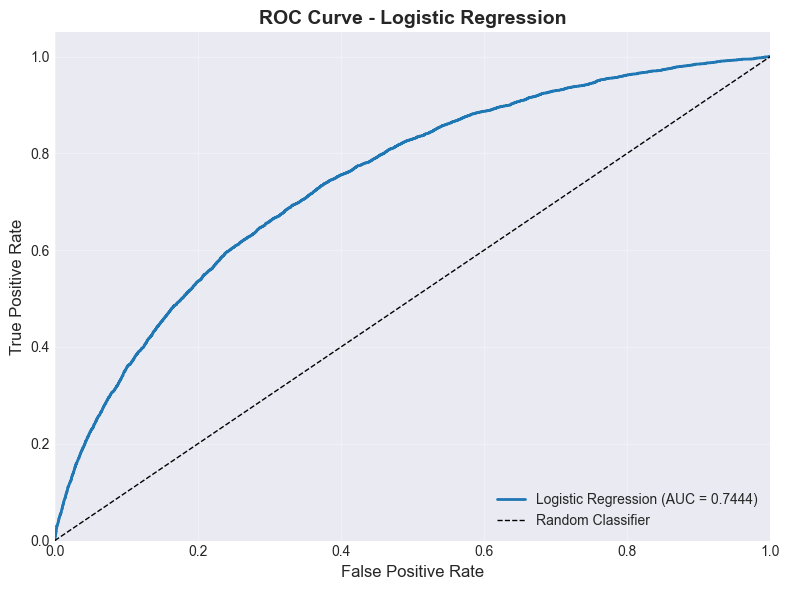

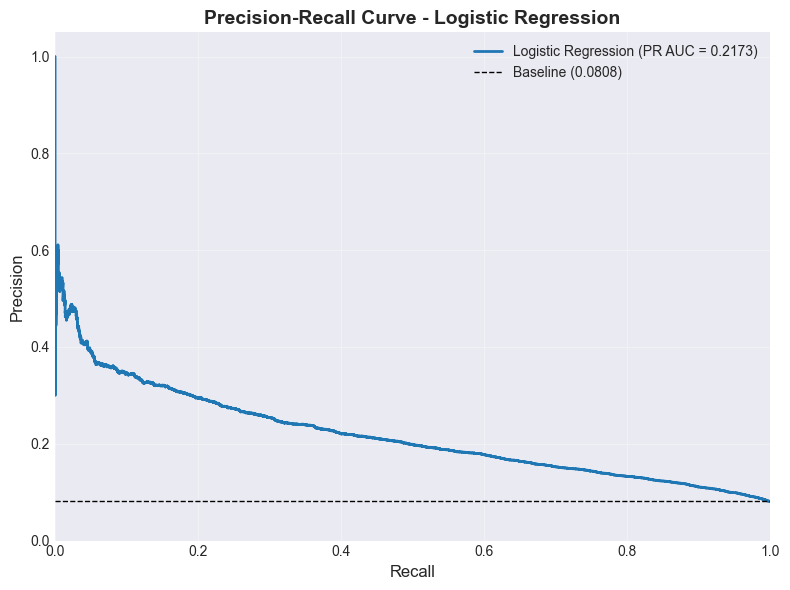

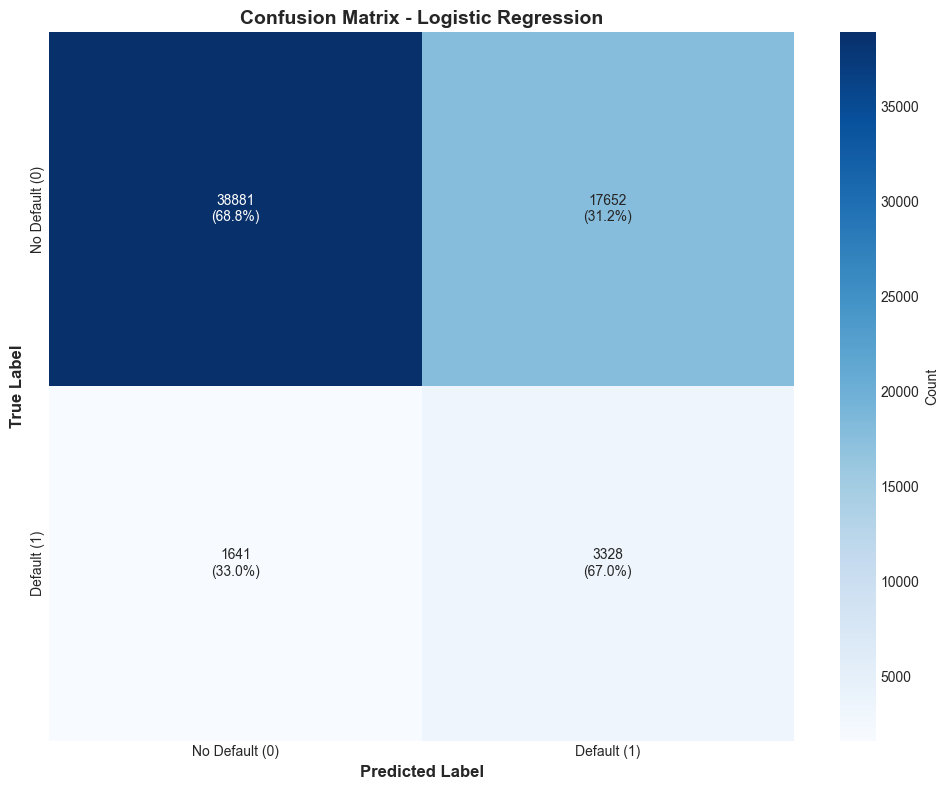


Confusion Matrix Details:
True Negatives:    38881 (63.22%)
False Positives:   17652 (28.70%)
False Negatives:    1641 ( 2.67%)
True Positives:     3328 ( 5.41%)

✓ Model saved to 'models/logistic_regression.pkl'


{'roc_auc': 0.7444190704281176,
 'pr_auc': 0.21729890680956243,
 'f1': 0.2565031407761378,
 'precision': 0.1586272640610105,
 'recall': 0.6697524652847655,
 'accuracy': 0.686302884459042,
 'brier': 0.20316360747122972}

In [14]:
# ==========================================
# 7.2 BASELINE MODEL 1: LOGISTIC REGRESSION
# ==========================================
print("\n" + "="*80)
print("7.2 LOGISTIC REGRESSION - BASELINE")
print("="*80)
print("Training on: train (60% of data)")
print("Evaluation on: val (20% of data)")

# Train Logistic Regression
lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_iter=1000,
    n_jobs=-1
)

print("\n⏳ Training Logistic Regression...")
lr_model.fit(X_train_scaled, y_train)
print("✓ Training completed!")

# Predictions on val set
print("\n⏳ Generating predictions on validation set...")
y_val_pred_lr = lr_model.predict_proba(X_val_scaled)[:, 1]

# Save and evaluate
save_model_results(
    model_name="Logistic Regression",
    model=lr_model,
    y_true=y_val,
    y_pred_proba=y_val_pred_lr,
    results_dict=results_dict,
    save_path="models/logistic_regression.pkl"
)


7.3 RANDOM FOREST - BASELINE
Training on: train (60% of data)
Evaluation on: val (20% of data)

⏳ Training Random Forest...
✓ Training completed!

⏳ Generating predictions on validation set...

📊 Classification Report:
                precision    recall  f1-score   support

No Default (0)       0.94      0.91      0.93     56533
   Default (1)       0.24      0.30      0.27      4969

      accuracy                           0.86     61502
     macro avg       0.59      0.61      0.60     61502
  weighted avg       0.88      0.86      0.87     61502


                  Random Forest - Test Set                  
ROC AUC Score:     0.7331
PR AUC Score:      0.2074
F1 Score:          0.2671
Precision:         0.2378
Recall:            0.3047
Accuracy:          0.8649
Brier Score:       0.1164

📈 Generating visualizations for Random Forest...


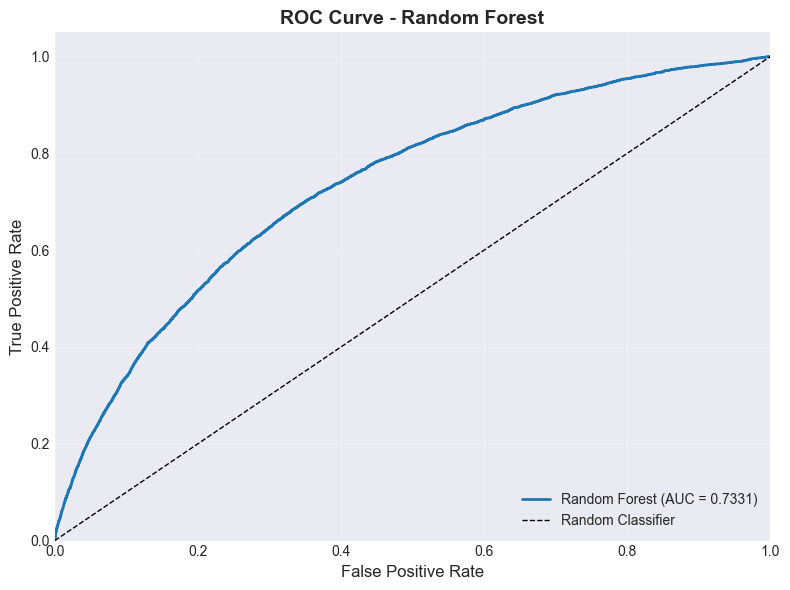

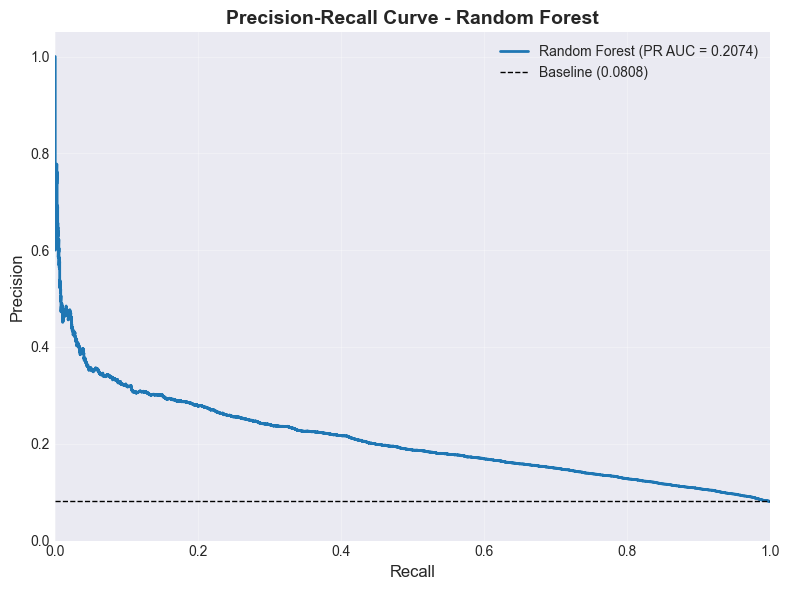

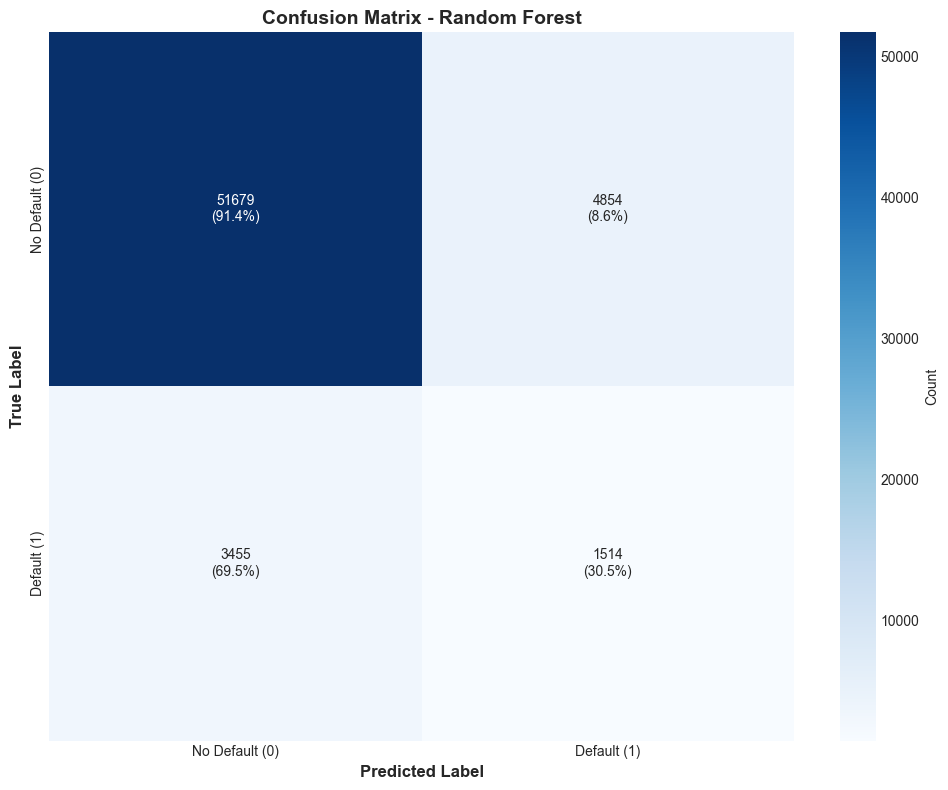


Confusion Matrix Details:
True Negatives:    51679 (84.03%)
False Positives:    4854 ( 7.89%)
False Negatives:    3455 ( 5.62%)
True Positives:     1514 ( 2.46%)

✓ Model saved to 'models/random_forest.pkl'


{'roc_auc': 0.7331184972606254,
 'pr_auc': 0.20735586372599618,
 'f1': 0.26709005909852696,
 'precision': 0.23775125628140703,
 'recall': 0.30468907224793723,
 'accuracy': 0.8648987024812201,
 'brier': 0.11641693264126773}

In [15]:
# ==========================================
# 7.3 BASELINE MODEL 2: RANDOM FOREST
# ==========================================
print("\n" + "="*80)
print("7.3 RANDOM FOREST - BASELINE")
print("="*80)
print("Training on: train (60% of data)")
print("Evaluation on: val (20% of data)")

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1,
    max_depth=15,
    min_samples_split=5
)

print("\n⏳ Training Random Forest...")
rf_model.fit(X_train_scaled, y_train)
print("✓ Training completed!")

# Predictions on val set
print("\n⏳ Generating predictions on validation set...")
y_val_pred_rf = rf_model.predict_proba(X_val_scaled)[:, 1]

# Save and evaluate
save_model_results(
    model_name="Random Forest",
    model=rf_model,
    y_true=y_val,
    y_pred_proba=y_val_pred_rf,
    results_dict=results_dict,
    save_path="models/random_forest.pkl"
)


7.4 XGBOOST - BASELINE
Training on: train (60% of data)
Evaluation on: val (20% of data)
Scale pos weight: 11.38

⏳ Training XGBoost...
✓ Training completed!

⏳ Generating predictions on validation set...

📊 Classification Report:
                precision    recall  f1-score   support

No Default (0)       0.96      0.74      0.84     56533
   Default (1)       0.18      0.65      0.28      4969

      accuracy                           0.73     61502
     macro avg       0.57      0.69      0.56     61502
  weighted avg       0.90      0.73      0.79     61502


                     XGBoost - Test Set                     
ROC AUC Score:     0.7633
PR AUC Score:      0.2493
F1 Score:          0.2816
Precision:         0.1800
Recall:            0.6462
Accuracy:          0.7336
Brier Score:       0.1776

📈 Generating visualizations for XGBoost...


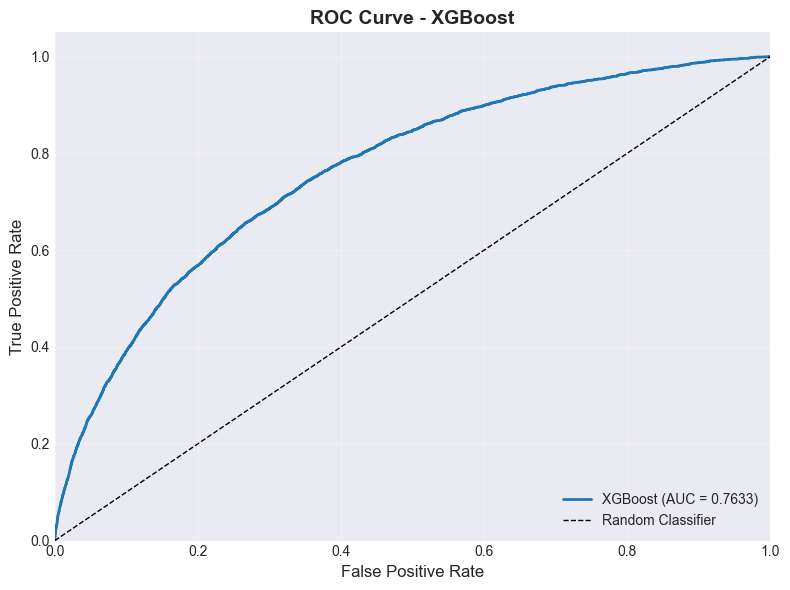

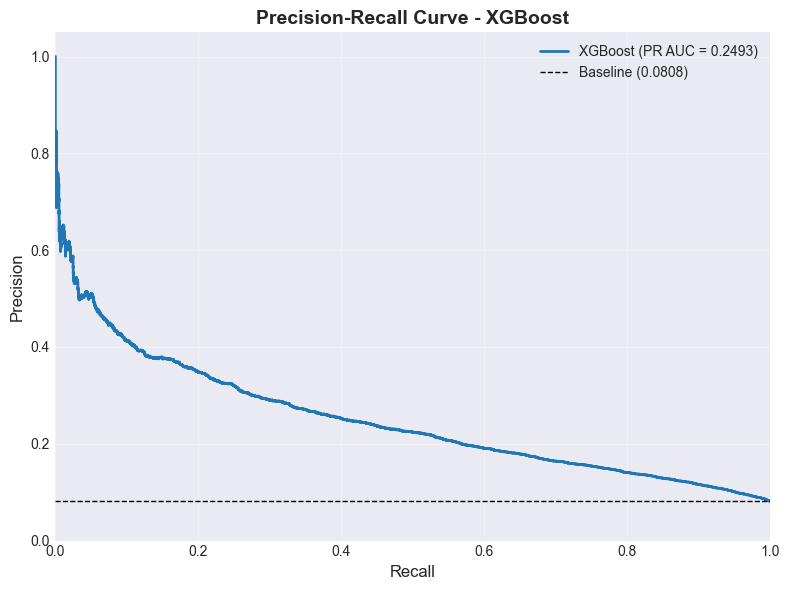

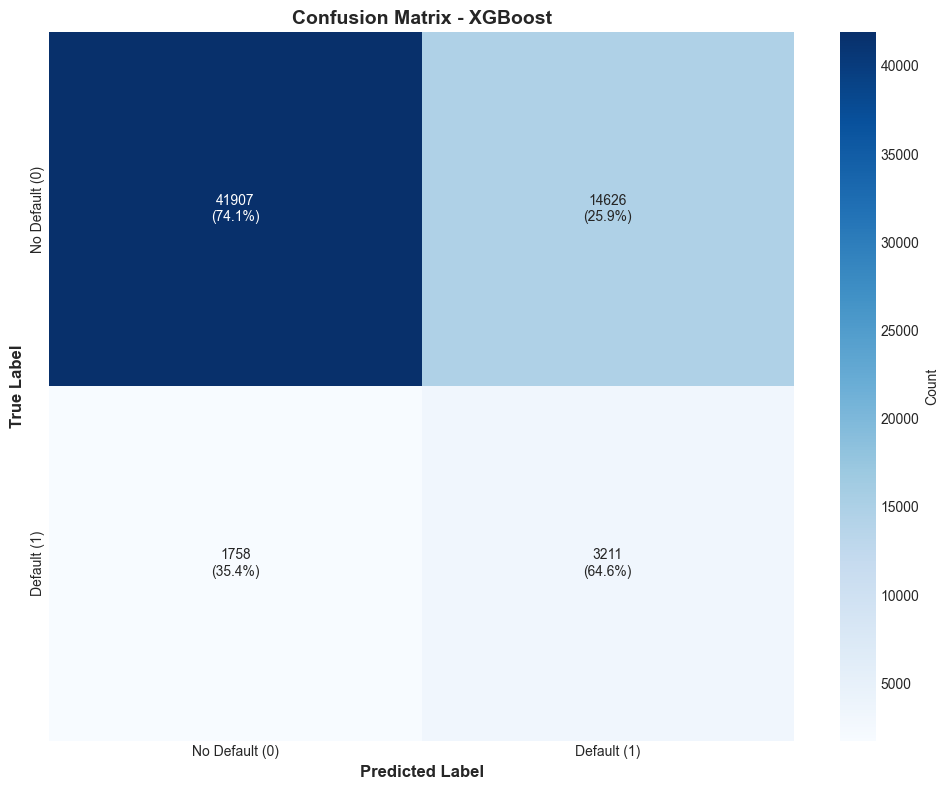


Confusion Matrix Details:
True Negatives:    41907 (68.14%)
False Positives:   14626 (23.78%)
False Negatives:    1758 ( 2.86%)
True Positives:     3211 ( 5.22%)

✓ Model saved to 'models/xgboost.pkl'


{'roc_auc': 0.7632587124280706,
 'pr_auc': 0.24928572770637583,
 'f1': 0.2815925633605192,
 'precision': 0.18001906150137356,
 'recall': 0.646206480177098,
 'accuracy': 0.733602159279373,
 'brier': 0.17755472660064697}

In [16]:
# ==========================================
# 7.4 BASELINE MODEL 3: XGBOOST (Standard)
# ==========================================
print("\n" + "="*80)
print("7.4 XGBOOST - BASELINE")
print("="*80)
print("Training on: train (60% of data)")
print("Evaluation on: val (20% of data)")

# Calculate scale_pos_weight
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    objective='binary:logistic',
    eval_metric='auc',
    n_jobs=-1
)

print("\n⏳ Training XGBoost...")
xgb_model.fit(X_train_scaled, y_train)
print("✓ Training completed!")

# Predictions on val set
print("\n⏳ Generating predictions on validation set...")
y_val_pred_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

# Save and evaluate
save_model_results(
    model_name="XGBoost",
    model=xgb_model,
    y_true=y_val,
    y_pred_proba=y_val_pred_xgb,
    results_dict=results_dict,
    save_path="models/xgboost.pkl"
)


7.5 LIGHTGBM - BASELINE
Training on: train (60% of data)
Evaluation on: val (20% of data)

⏳ Training LightGBM...
✓ Training completed!

⏳ Generating predictions on validation set...

📊 Classification Report:
                precision    recall  f1-score   support

No Default (0)       0.96      0.73      0.83     56533
   Default (1)       0.18      0.67      0.28      4969

      accuracy                           0.72     61502
     macro avg       0.57      0.70      0.55     61502
  weighted avg       0.90      0.72      0.78     61502


                    LightGBM - Test Set                     
ROC AUC Score:     0.7670
PR AUC Score:      0.2545
F1 Score:          0.2802
Precision:         0.1770
Recall:            0.6716
Accuracy:          0.7212
Brier Score:       0.1831

📈 Generating visualizations for LightGBM...


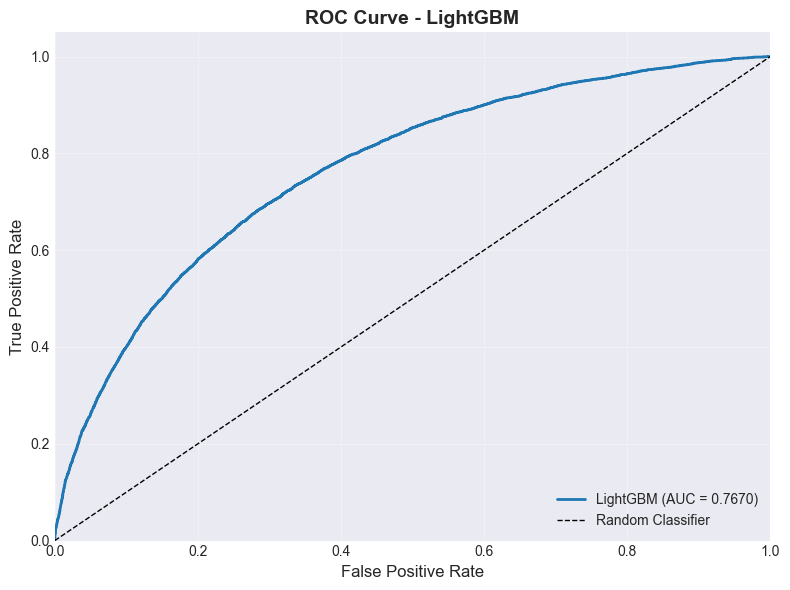

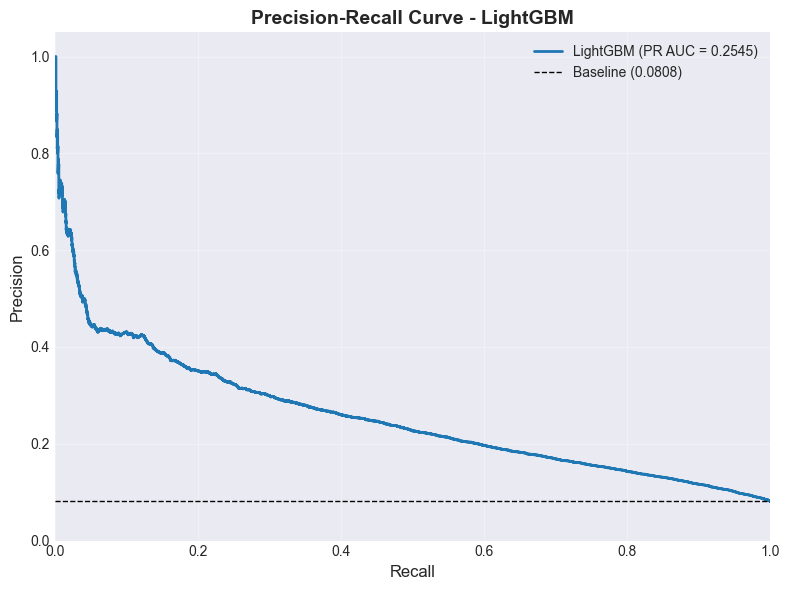

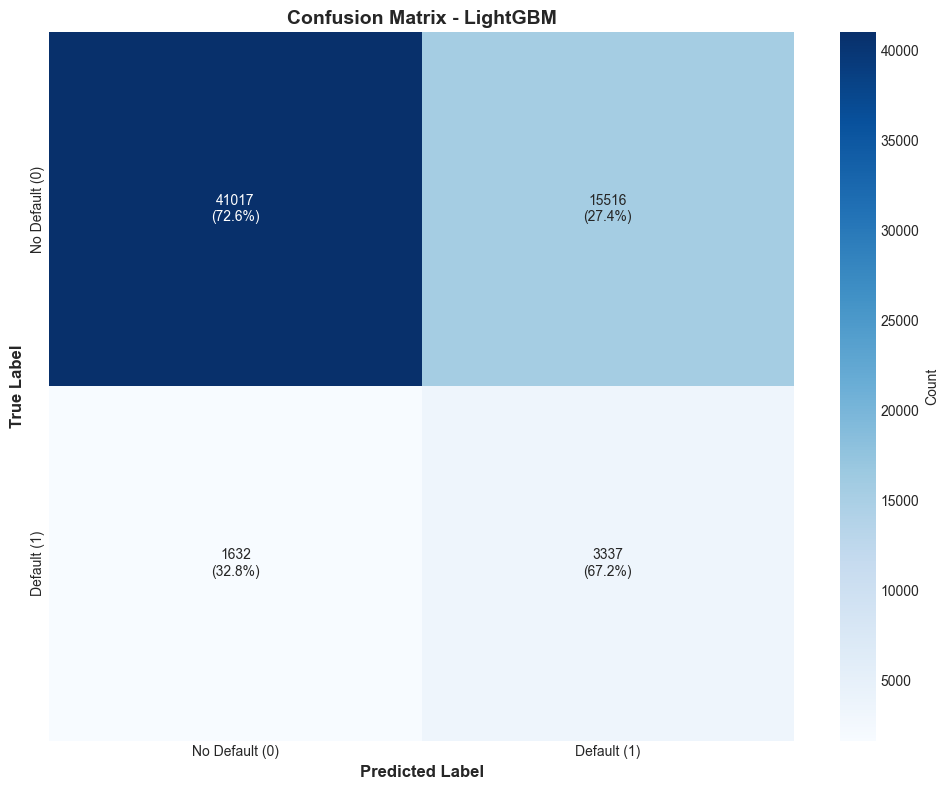


Confusion Matrix Details:
True Negatives:    41017 (66.69%)
False Positives:   15516 (25.23%)
False Negatives:    1632 ( 2.65%)
True Positives:     3337 ( 5.43%)

✓ Model saved to 'models/lightgbm.pkl'


{'roc_auc': 0.7669925106245815,
 'pr_auc': 0.25454382640088685,
 'f1': 0.2801611955335404,
 'precision': 0.17700100779716757,
 'recall': 0.6715636949084323,
 'accuracy': 0.7211797990309258,
 'brier': 0.183147342602059}

In [17]:
# ==========================================
# 7.5 BASELINE MODEL 4: LIGHTGBM (Standard)
# ==========================================
print("\n" + "="*80)
print("7.5 LIGHTGBM - BASELINE")
print("="*80)
print("Training on: train (60% of data)")
print("Evaluation on: val (20% of data)")

# Train LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1,
    verbose=-1
)

print("\n⏳ Training LightGBM...")
lgb_model.fit(X_train_scaled, y_train)
print("✓ Training completed!")

# Predictions on val set
print("\n⏳ Generating predictions on validation set...")
y_val_pred_lgb = lgb_model.predict_proba(X_val_scaled)[:, 1]

# Save and evaluate
save_model_results(
    model_name="LightGBM",
    model=lgb_model,
    y_true=y_val,
    y_pred_proba=y_val_pred_lgb,
    results_dict=results_dict,
    save_path="models/lightgbm.pkl"
)

### 7.8 Model Comparison

So sánh performance của tất cả baseline models

In [18]:
# ==========================================
# MODEL COMPARISON
# ==========================================
print("\n" + "="*80)
print("7.8 BASELINE MODELS COMPARISON")
print("="*80)

# Tạo comparison DataFrame
comparison_df = pd.DataFrame(results_dict).T
comparison_df = comparison_df[['roc_auc', 'pr_auc', 'f1', 'precision', 'recall', 'accuracy', 'brier']]

print("\n📊 Model Performance on Validation Set:")
print("="*100)
print(comparison_df.round(4).to_string())
print("="*100)

# Find best model theo PR AUC
best_model_name = comparison_df['pr_auc'].idxmax()
print(f"\n🏆 Best Model (by PR AUC): {best_model_name}")
print(f"   PR AUC:    {comparison_df.loc[best_model_name, 'pr_auc']:.4f}")
print(f"   ROC AUC:   {comparison_df.loc[best_model_name, 'roc_auc']:.4f}")
print(f"   F1 Score:  {comparison_df.loc[best_model_name, 'f1']:.4f}")
print(f"   Precision: {comparison_df.loc[best_model_name, 'precision']:.4f}")
print(f"   Recall:    {comparison_df.loc[best_model_name, 'recall']:.4f}")

# Lưu comparison
comparison_df.to_csv('models/baseline_comparison.csv')
print("\n✓ Comparison saved to 'models/baseline_comparison.csv'")


7.8 BASELINE MODELS COMPARISON

📊 Model Performance on Validation Set:
                     roc_auc  pr_auc      f1  precision  recall  accuracy   brier
Logistic Regression   0.7444  0.2173  0.2565     0.1586  0.6698    0.6863  0.2032
Random Forest         0.7331  0.2074  0.2671     0.2378  0.3047    0.8649  0.1164
XGBoost               0.7633  0.2493  0.2816     0.1800  0.6462    0.7336  0.1776
LightGBM              0.7670  0.2545  0.2802     0.1770  0.6716    0.7212  0.1831

🏆 Best Model (by PR AUC): LightGBM
   PR AUC:    0.2545
   ROC AUC:   0.7670
   F1 Score:  0.2802
   Precision: 0.1770
   Recall:    0.6716

✓ Comparison saved to 'models/baseline_comparison.csv'


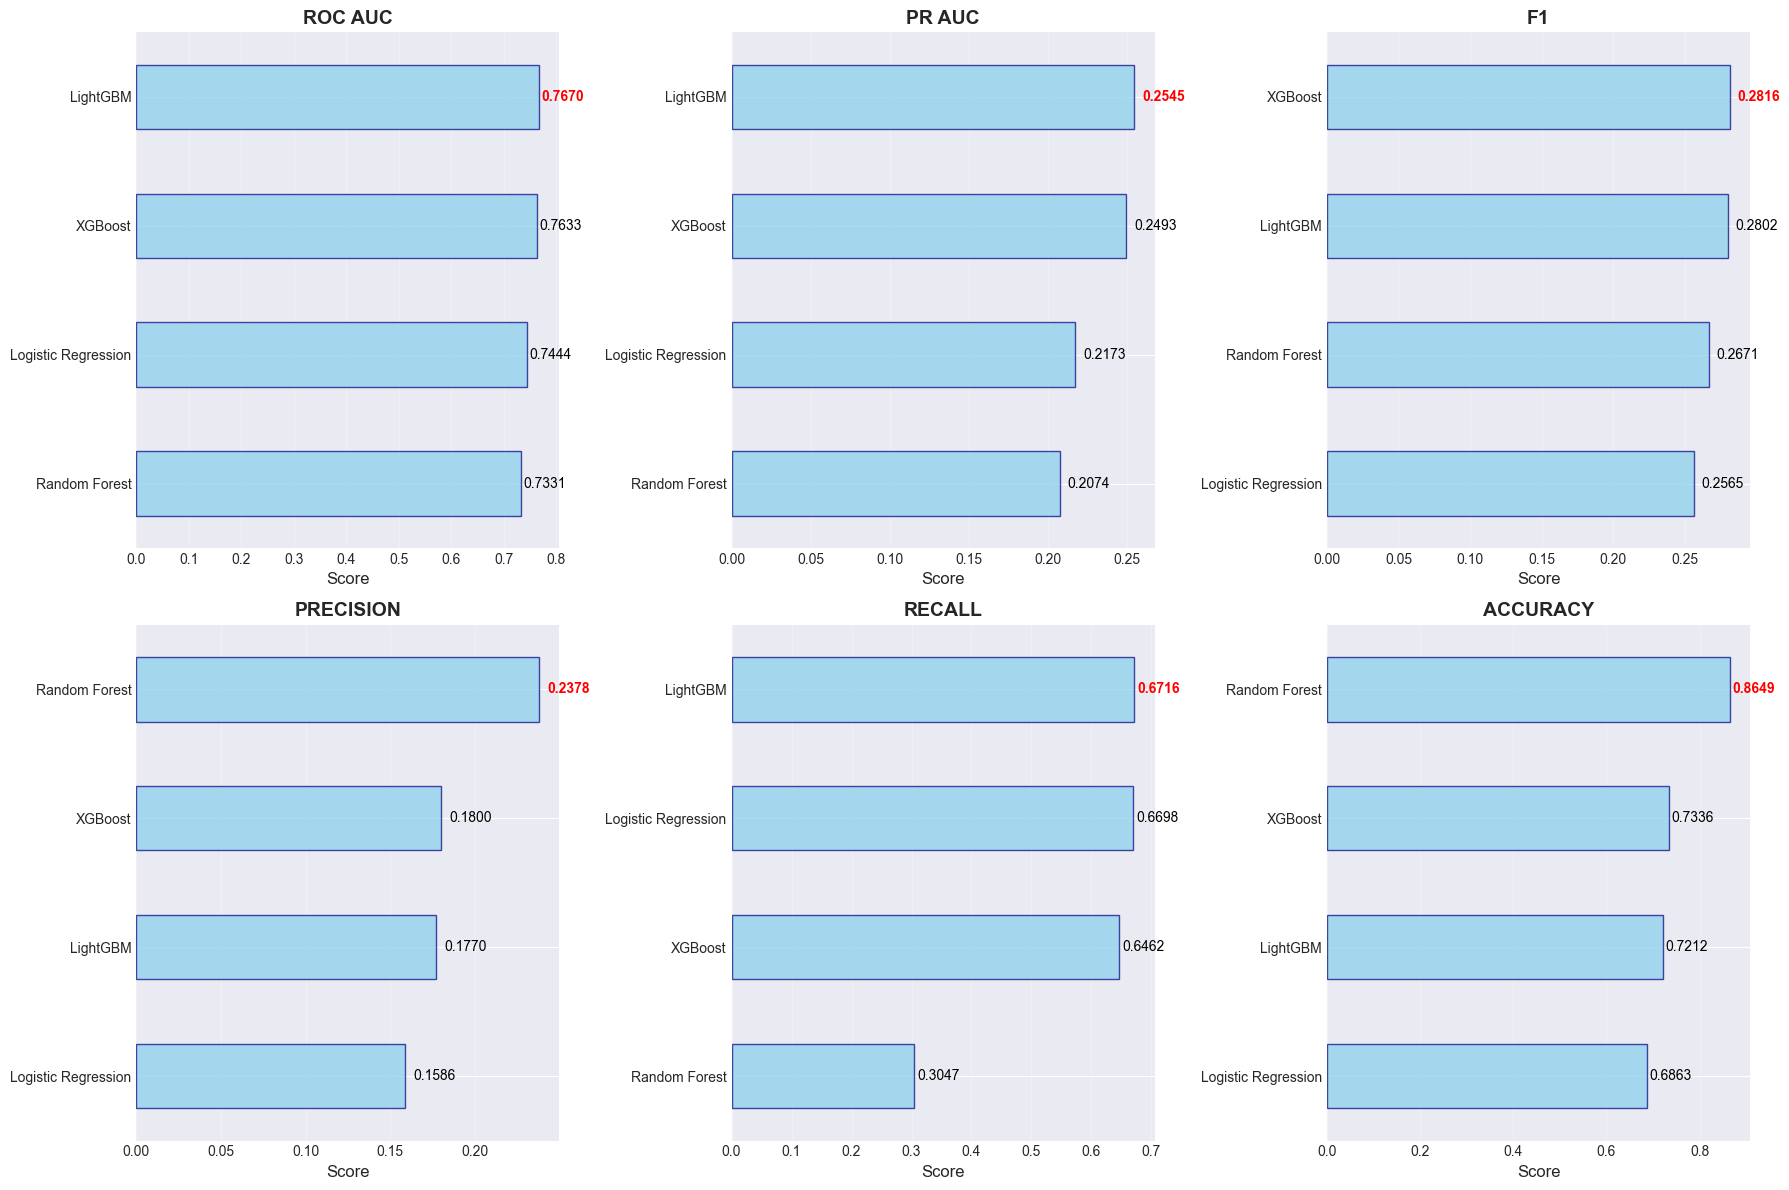

✓ Comparison chart saved as 'models/baseline_comparison.png'


In [19]:
# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_to_plot = ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall', 'accuracy']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    comparison_df[metric].sort_values().plot(kind='barh', ax=ax, color='skyblue', edgecolor='navy', alpha=0.7)
    ax.set_title(f'{metric.upper().replace("_", " ")}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Score', fontsize=12)
    ax.grid(axis='x', alpha=0.3)
    
    # Highlight best model
    best_idx = comparison_df[metric].idxmax()
    for i, (name, v) in enumerate(comparison_df[metric].sort_values().items()):
        color = 'red' if name == best_idx else 'black'
        weight = 'bold' if name == best_idx else 'normal'
        ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10, color=color, weight=weight)

plt.tight_layout()
plt.savefig('models/baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison chart saved as 'models/baseline_comparison.png'")

In [20]:
# ==========================================
# HYPERPARAMETER TUNING WITH HYPEROPT - LIGHTGBM
# ==========================================
print("\n" + "="*80)
print("7.9 HYPERPARAMETER TUNING - LIGHTGBM")
print("="*80)

print(f"\n🏆 Selected model for tuning: LightGBM")
print(f"   Baseline PR AUC (on val): {comparison_df.loc['LightGBM', 'pr_auc']:.4f}")

# Training strategy - train trên train, tune trên val
print("\n📋 Strategy: Train on train (60%), tune on val (20%) - NO CROSS-VALIDATION")
X_tune_train = X_train_scaled
y_tune_train = y_train

print("\n⚙️ Model type: LightGBM")

def objective(params):
    """Objective function for LightGBM - Optimize PR AUC on validation set"""
    model_params = {
        'num_leaves': int(params['num_leaves']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'n_estimators': int(params['n_estimators']),
        'min_child_samples': int(params['min_child_samples']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'objective': 'binary',
        'class_weight': 'balanced',
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbose': -1
    }
    
    # Train trên train set
    model = lgb.LGBMClassifier(**model_params)
    model.fit(
        X_tune_train, y_tune_train,
        eval_set=[(X_val_scaled, y_val)],
        callbacks=[lgb.early_stopping(20, verbose=False)]
    )
    
    # Evaluate trên val set
    y_val_pred = model.predict_proba(X_val_scaled)[:, 1]
    score = average_precision_score(y_val, y_val_pred)
    
    return {'loss': -score, 'status': STATUS_OK, 'score': score}

# Define search space for LightGBM
space = {
    'num_leaves': hp.quniform('num_leaves', 20, 50, 1),
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'min_child_samples': hp.quniform('min_child_samples', 10, 50, 5),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 3),
    'reg_lambda': hp.uniform('reg_lambda', 0, 3)
}


7.9 HYPERPARAMETER TUNING - LIGHTGBM

🏆 Selected model for tuning: LightGBM
   Baseline PR AUC (on val): 0.2545

📋 Strategy: Train on train (60%), tune on val (20%) - NO CROSS-VALIDATION

⚙️ Model type: LightGBM


In [21]:
# ==========================================
# RUN HYPEROPT OPTIMIZATION
# ==========================================
print("\n" + "="*80)
print("RUNNING HYPEROPT OPTIMIZATION")
print("="*80)
print(f"Max evaluations: 50")
print(f"Algorithm: TPE (Tree-structured Parzen Estimator)")
print(f"Optimization target: PR AUC on validation set (NO cross-validation)")

# Initialize Trials
trials = Trials()

# Counter for progress tracking
iteration_counter = {'count': 0}

# Modified objective function with progress logging
def objective_with_logging(params):
    """Objective function with progress logging"""
    result = objective(params)
    
    # Update counter and print progress
    iteration_counter['count'] += 1
    iter_num = iteration_counter['count']
    pr_auc = result['score']
    
    print(f"\n{'='*60}")
    print(f"Iteration {iter_num}/50 - PR AUC (val): {pr_auc:.4f}")
    print(f"{'='*60}")
    print("Parameters tested:")
    for key, value in params.items():
        if isinstance(value, (int, np.integer)):
            print(f"  {key:20s}: {int(value)}")
        else:
            print(f"  {key:20s}: {value:.6f}")
    
    return result

# Run optimization
print("\n⏳ Starting optimization (this may take a while)...")
print("Progress will be shown for each iteration...\n")
best_params = fmin(
    fn=objective_with_logging,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(RANDOM_STATE),
    verbose=0  # Set to 0 to avoid duplicate output
)

# Get best params từ space
best_params = space_eval(space, best_params)

# Get best score
best_score = -min([trial['result']['loss'] for trial in trials.trials])

print("\n" + "="*80)
print("OPTIMIZATION RESULTS")
print("="*80)
print(f"\n🏆 Best PR AUC (val): {best_score:.4f}")
print(f"   Improvement: {best_score - comparison_df.loc['LightGBM', 'pr_auc']:.4f}")
print(f"\n✅ Best parameters:")
for param, value in best_params.items():
    if isinstance(value, (int, np.integer)):
        print(f"   {param}: {int(value)}")
    else:
        print(f"   {param}: {value:.6f}")

# Save best params
import json
with open('models/best_hyperparams.json', 'w') as f:
    # Convert numpy types to Python types
    best_params_serializable = {}
    for k, v in best_params.items():
        if isinstance(v, (np.integer, np.int64, np.int32)):
            best_params_serializable[k] = int(v)
        elif isinstance(v, (np.floating, np.float64, np.float32)):
            best_params_serializable[k] = float(v)
        else:
            best_params_serializable[k] = v
    json.dump(best_params_serializable, f, indent=2)
print("\n✓ Best parameters saved to 'models/best_hyperparams.json'")


RUNNING HYPEROPT OPTIMIZATION
Max evaluations: 50
Algorithm: TPE (Tree-structured Parzen Estimator)
Optimization target: PR AUC on validation set (NO cross-validation)

⏳ Starting optimization (this may take a while)...
Progress will be shown for each iteration...


Iteration 1/50 - PR AUC (val): 0.2534
Parameters tested:
  colsample_bytree    : 0.793674
  learning_rate       : 0.026396
  max_depth           : 12.000000
  min_child_samples   : 15.000000
  n_estimators        : 240.000000
  num_leaves          : 40.000000
  reg_alpha           : 2.651780
  reg_lambda          : 1.860357
  subsample           : 0.925462

Iteration 2/50 - PR AUC (val): 0.2229
Parameters tested:
  colsample_bytree    : 0.736749
  learning_rate       : 0.010166
  max_depth           : 14.000000
  min_child_samples   : 15.000000
  n_estimators        : 190.000000
  num_leaves          : 22.000000
  reg_alpha           : 2.582791
  reg_lambda          : 1.824747
  subsample           : 0.720169

Iteration 3/


HYPERPARAMETER OPTIMIZATION ANALYSIS

📊 Generating optimization analysis charts...


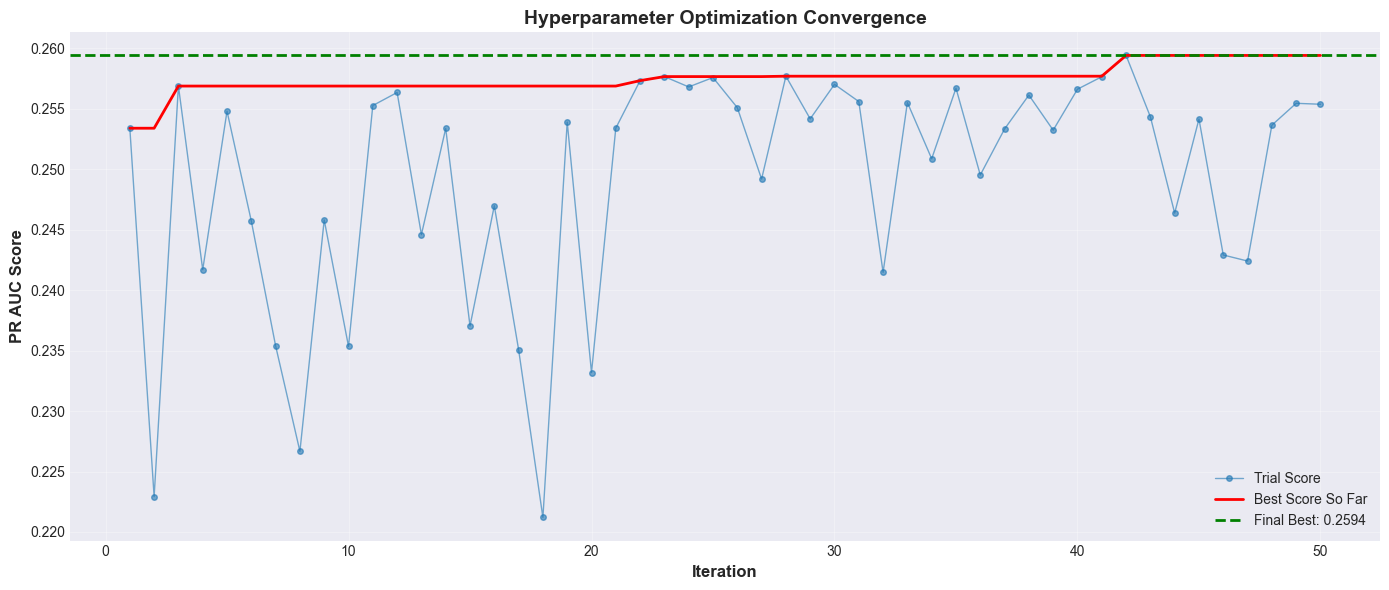

✓ Convergence plot saved as 'models/hyperopt_convergence.png'


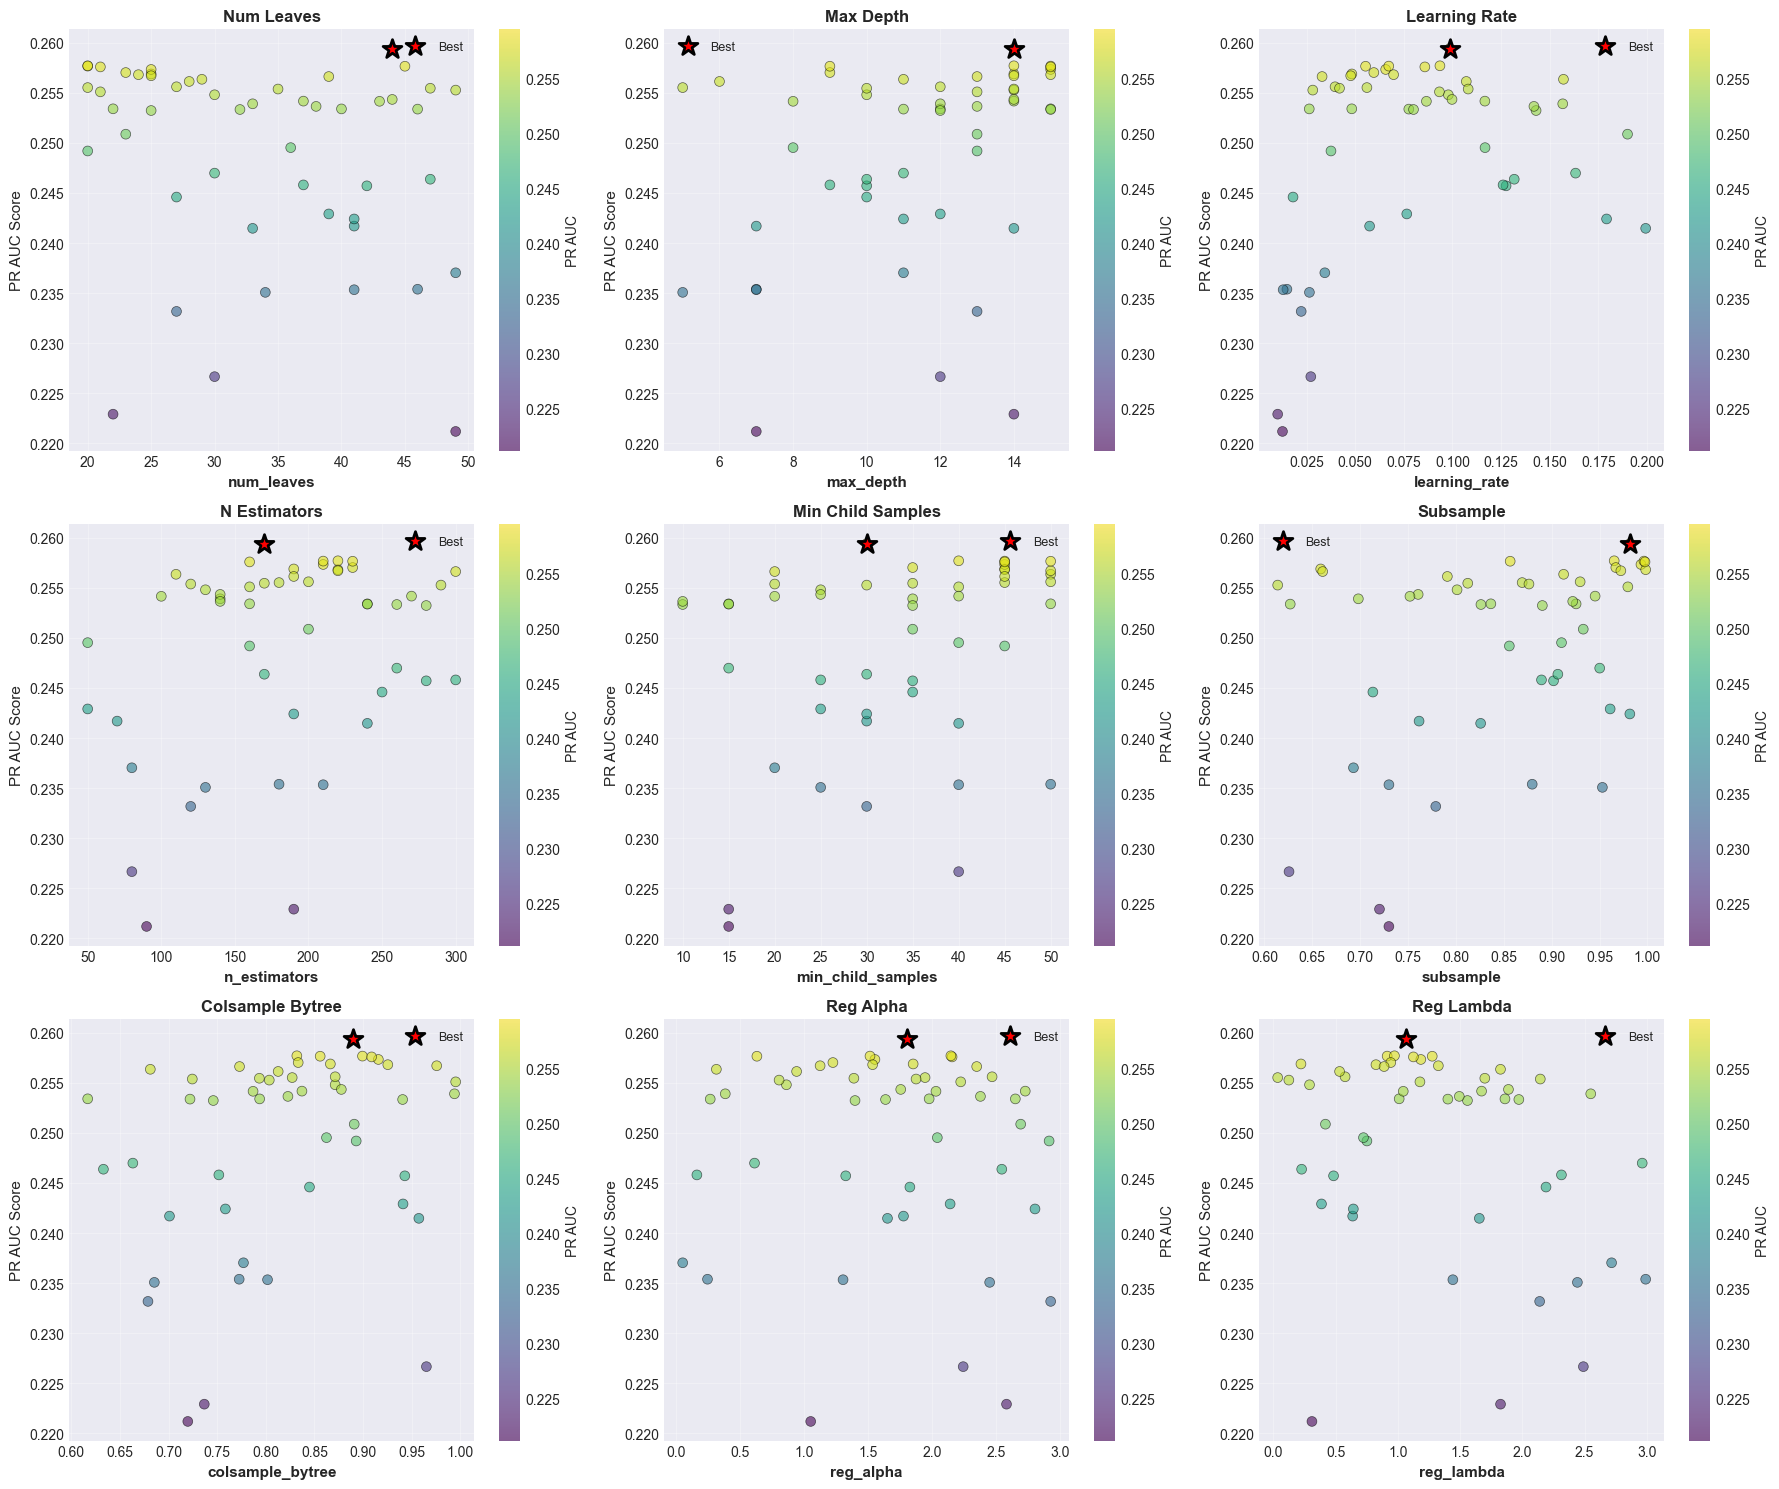

✓ Parameter distributions saved as 'models/hyperopt_parameter_distributions.png'


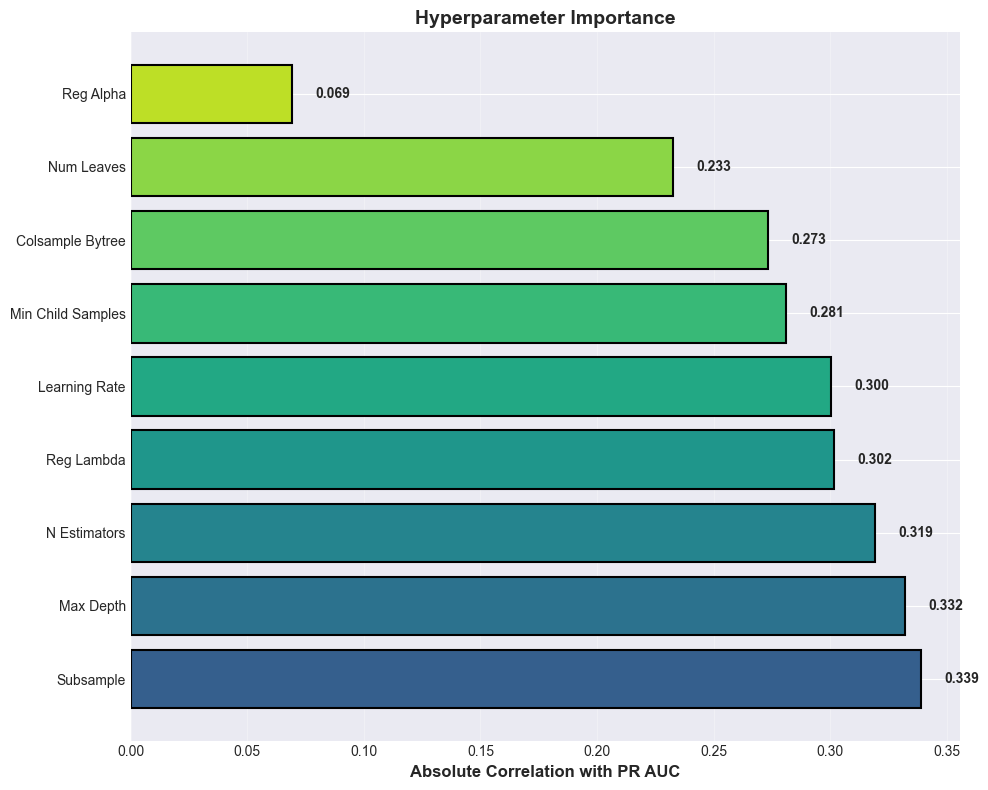

✓ Parameter importance saved as 'models/hyperopt_parameter_importance.png'

OPTIMIZATION STATISTICS

Total iterations:        50
Best PR AUC:            0.2594
Worst PR AUC:           0.2212
Mean PR AUC:            0.2492
Std PR AUC:             0.0095
Improvement range:      0.0382

Best score found at:    Iteration 42
Iterations after best:  8

✅ Hyperparameter optimization analysis completed!


In [22]:
# ==========================================
# VISUALIZATION: HYPERPARAMETER OPTIMIZATION ANALYSIS
# ==========================================
print("\n" + "="*80)
print("HYPERPARAMETER OPTIMIZATION ANALYSIS")
print("="*80)

# Extract results from trials
trial_scores = [-trial['result']['loss'] for trial in trials.trials]
trial_iterations = list(range(1, len(trial_scores) + 1))

# Get parameter values for each trial
param_names = list(space.keys())
param_values = {param: [] for param in param_names}

for trial in trials.trials:
    trial_params = trial['misc']['vals']
    for param in param_names:
        # Extract the value (hyperopt stores as list)
        val = trial_params[param][0] if trial_params[param] else None
        param_values[param].append(val)

print(f"\n📊 Generating optimization analysis charts...")

# ==========================================
# 1. CONVERGENCE PLOT: PR AUC over iterations
# ==========================================
fig, ax = plt.subplots(figsize=(14, 6))

# Plot all trials
ax.plot(trial_iterations, trial_scores, 'o-', alpha=0.6, label='Trial Score', markersize=4, linewidth=1)

# Plot best score so far (cumulative maximum)
best_scores_so_far = [max(trial_scores[:i+1]) for i in range(len(trial_scores))]
ax.plot(trial_iterations, best_scores_so_far, 'r-', linewidth=2, label='Best Score So Far')

# Mark final best
ax.axhline(y=best_score, color='green', linestyle='--', linewidth=2, label=f'Final Best: {best_score:.4f}')

ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('PR AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Hyperparameter Optimization Convergence', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('models/hyperopt_convergence.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Convergence plot saved as 'models/hyperopt_convergence.png'")

# ==========================================
# 2. PARAMETER DISTRIBUTIONS
# ==========================================
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, param in enumerate(param_names):
    ax = axes[idx]
    values = param_values[param]
    scores = trial_scores
    
    # Scatter plot: parameter value vs score
    scatter = ax.scatter(values, scores, c=scores, cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # Mark best parameter value
    best_trial_idx = np.argmax(scores)
    best_param_value = values[best_trial_idx]
    ax.scatter([best_param_value], [max(scores)], color='red', s=200, marker='*', 
               edgecolors='black', linewidth=2, label='Best', zorder=5)
    
    ax.set_xlabel(f'{param}', fontsize=11, fontweight='bold')
    ax.set_ylabel('PR AUC Score', fontsize=11)
    ax.set_title(f'{param.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(fontsize=9)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='PR AUC')

plt.tight_layout()
plt.savefig('models/hyperopt_parameter_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Parameter distributions saved as 'models/hyperopt_parameter_distributions.png'")

# ==========================================
# 3. PARAMETER IMPORTANCE (Correlation with Score)
# ==========================================
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate correlation between each parameter and score
correlations = {}
for param in param_names:
    values = param_values[param]
    correlation = np.corrcoef(values, trial_scores)[0, 1]
    correlations[param] = abs(correlation)  # Use absolute value

# Sort by importance
sorted_params = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
param_labels = [p[0].replace('_', ' ').title() for p in sorted_params]
param_importances = [p[1] for p in sorted_params]

# Create horizontal bar chart
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(param_labels)))
bars = ax.barh(param_labels, param_importances, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, param_importances)):
    ax.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Absolute Correlation with PR AUC', fontsize=12, fontweight='bold')
ax.set_title('Hyperparameter Importance', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('models/hyperopt_parameter_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Parameter importance saved as 'models/hyperopt_parameter_importance.png'")

# ==========================================
# 4. OPTIMIZATION SUMMARY STATISTICS
# ==========================================
print("\n" + "="*80)
print("OPTIMIZATION STATISTICS")
print("="*80)
print(f"\nTotal iterations:        {len(trial_scores)}")
print(f"Best PR AUC:            {best_score:.4f}")
print(f"Worst PR AUC:           {min(trial_scores):.4f}")
print(f"Mean PR AUC:            {np.mean(trial_scores):.4f}")
print(f"Std PR AUC:             {np.std(trial_scores):.4f}")
print(f"Improvement range:      {best_score - min(trial_scores):.4f}")

# Find when best score was achieved
best_iteration = np.argmax(trial_scores) + 1
print(f"\nBest score found at:    Iteration {best_iteration}")
print(f"Iterations after best:  {len(trial_scores) - best_iteration}")

print("\n✅ Hyperparameter optimization analysis completed!")
print("="*80)

## 8. Train Final Model with Optimized Hyperparameters

Sau khi tìm được best hyperparameters, chúng ta sẽ:
1. Train LightGBM với best params trên train set (60%)
2. Phân tích Feature Importance với SHAP (sử dụng val set)
3. Calibrate model với Isotonic Regression sử dụng val set

### 8.1 Train Final LightGBM Model

In [23]:
# ==========================================
# 8.1 TRAIN FINAL MODEL WITH BEST HYPERPARAMETERS
# ==========================================
print("\n" + "="*80)
print("8.1 TRAINING FINAL LIGHTGBM MODEL")
print("="*80)

# Prepare final model parameters
final_model_params = {
    'num_leaves': int(best_params['num_leaves']),
    'max_depth': int(best_params['max_depth']),
    'learning_rate': best_params['learning_rate'],
    'n_estimators': int(best_params['n_estimators']),
    'min_child_samples': int(best_params['min_child_samples']),
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
    'objective': 'binary',
    'class_weight': 'balanced',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}

print("\n📋 Final Model Configuration:")
for param, value in final_model_params.items():
    if isinstance(value, (int, np.integer)):
        print(f"  {param:20s}: {int(value)}")
    elif isinstance(value, float):
        print(f"  {param:20s}: {value:.6f}")
    else:
        print(f"  {param:20s}: {value}")

# Train final model on TRAIN SET (60% data)
print("\n⏳ Training final model on train set (60% of data)...")
final_lgb_model = lgb.LGBMClassifier(**final_model_params)
final_lgb_model.fit(X_train_scaled, y_train)
print("✓ Training completed!")

# Evaluate on validation set
y_val_pred_tuned = final_lgb_model.predict_proba(X_val_scaled)[:, 1]
val_pr_auc = average_precision_score(y_val, y_val_pred_tuned)
val_roc_auc = roc_auc_score(y_val, y_val_pred_tuned)

print(f"\n📊 Performance on Validation Set:")
print(f"   ROC AUC: {val_roc_auc:.4f}")
print(f"   PR AUC:  {val_pr_auc:.4f}")

# Lưu model
joblib.dump(final_lgb_model, 'models/lightgbm_tuned.pkl')
print("\n✓ Final tuned model saved to 'models/lightgbm_tuned.pkl'")


8.1 TRAINING FINAL LIGHTGBM MODEL

📋 Final Model Configuration:
  num_leaves          : 44
  max_depth           : 14
  learning_rate       : 0.098603
  n_estimators        : 170
  min_child_samples   : 30
  subsample           : 0.981687
  colsample_bytree    : 0.889765
  reg_alpha           : 1.804285
  reg_lambda          : 1.064004
  objective           : binary
  class_weight        : balanced
  random_state        : 42
  n_jobs              : -1
  verbose             : -1

⏳ Training final model on train set (60% of data)...
✓ Training completed!

📊 Performance on Validation Set:
   ROC AUC: 0.7671
   PR AUC:  0.2594

✓ Final tuned model saved to 'models/lightgbm_tuned.pkl'


So sánh performance của model đã tune với các baseline models trên validation set


8.2.1 TUNED MODEL vs BASELINE MODELS COMPARISON

📊 All Models Performance on Validation Set:
                     roc_auc  pr_auc      f1  precision  recall  accuracy   brier
Logistic Regression   0.7444  0.2173  0.2565     0.1586  0.6698    0.6863  0.2032
Random Forest         0.7331  0.2074  0.2671     0.2378  0.3047    0.8649  0.1164
XGBoost               0.7633  0.2493  0.2816     0.1800  0.6462    0.7336  0.1776
LightGBM              0.7670  0.2545  0.2802     0.1770  0.6716    0.7212  0.1831
LightGBM (Tuned)      0.7671  0.2594  0.2888     0.1868  0.6367    0.7466  0.1692

🎯 Hyperparameter Tuning Results:
  Baseline LightGBM PR AUC:  0.2545
  Tuned LightGBM PR AUC:     0.2594
  Absolute Improvement:      +0.0049
  Relative Improvement:      +1.91%

🏆 Overall Best Model: LightGBM (Tuned)
   PR AUC:    0.2594
   ROC AUC:   0.7671
   F1 Score:  0.2888

✓ Final comparison saved to 'models/final_model_comparison.csv'


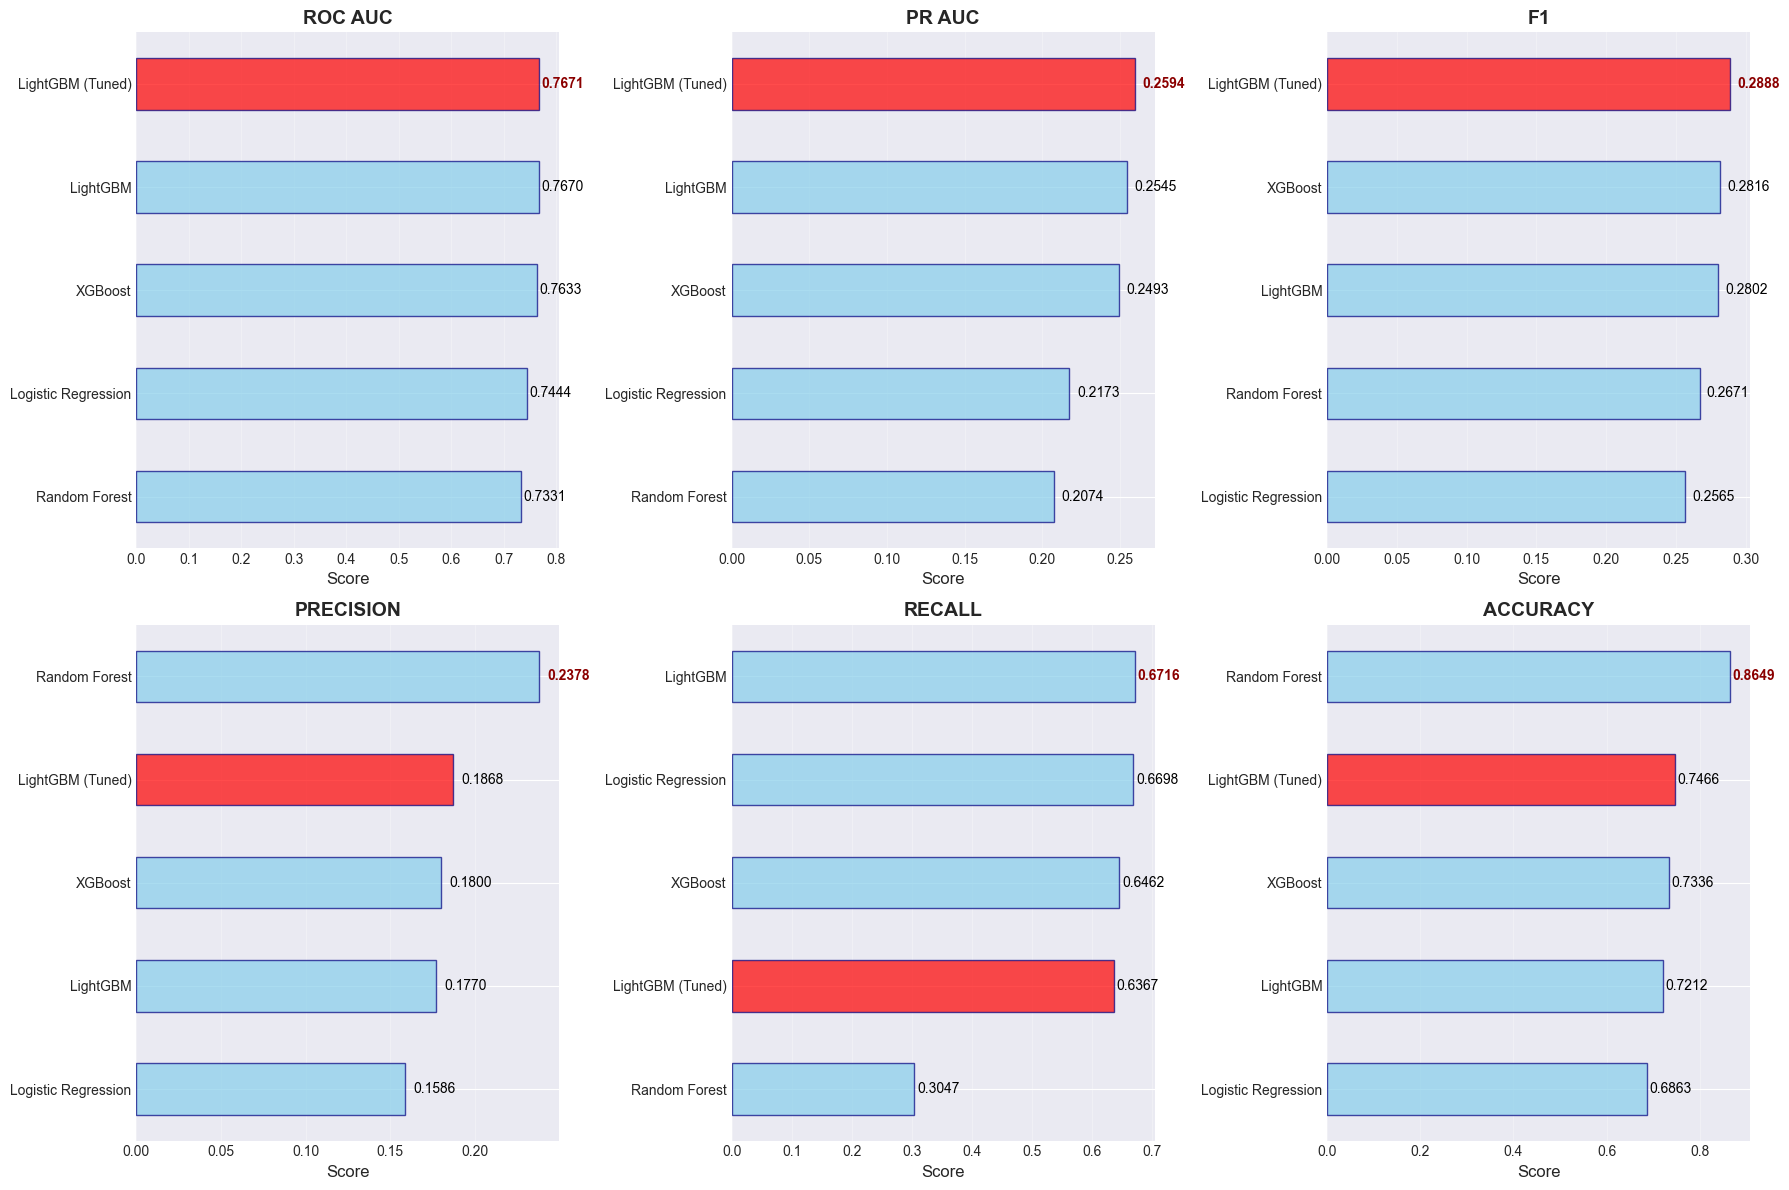

✓ Final comparison chart saved as 'models/final_model_comparison.png'

✅ Model comparison completed!


In [24]:
# ==========================================
# 8.2.1 COMPARE TUNED MODEL WITH BASELINE MODELS
# ==========================================
print("\n" + "="*80)
print("8.2.1 TUNED MODEL vs BASELINE MODELS COMPARISON")
print("="*80)

# Add tuned model results to comparison
results_dict["LightGBM (Tuned)"] = {
    'roc_auc': val_roc_auc,
    'pr_auc': val_pr_auc,
    'brier': brier_score_loss(y_val, y_val_pred_tuned),
    'f1': f1_score(y_val, (y_val_pred_tuned >= 0.5).astype(int)),
    'precision': precision_score(y_val, (y_val_pred_tuned >= 0.5).astype(int)),
    'recall': recall_score(y_val, (y_val_pred_tuned >= 0.5).astype(int)),
    'accuracy': accuracy_score(y_val, (y_val_pred_tuned >= 0.5).astype(int))
}

# Update comparison DataFrame
final_comparison_df = pd.DataFrame(results_dict).T
final_comparison_df = final_comparison_df[['roc_auc', 'pr_auc', 'f1', 'precision', 'recall', 'accuracy', 'brier']]

print("\n📊 All Models Performance on Validation Set:")
print("="*100)
print(final_comparison_df.round(4).to_string())
print("="*100)

# Calculate improvements
baseline_pr_auc = final_comparison_df.loc['LightGBM', 'pr_auc']
tuned_pr_auc = final_comparison_df.loc['LightGBM (Tuned)', 'pr_auc']
improvement = tuned_pr_auc - baseline_pr_auc
improvement_pct = (improvement / baseline_pr_auc) * 100

print(f"\n🎯 Hyperparameter Tuning Results:")
print(f"  Baseline LightGBM PR AUC:  {baseline_pr_auc:.4f}")
print(f"  Tuned LightGBM PR AUC:     {tuned_pr_auc:.4f}")
print(f"  Absolute Improvement:      +{improvement:.4f}")
print(f"  Relative Improvement:      +{improvement_pct:.2f}%")

# Find overall best model
overall_best = final_comparison_df['pr_auc'].idxmax()
print(f"\n🏆 Overall Best Model: {overall_best}")
print(f"   PR AUC:    {final_comparison_df.loc[overall_best, 'pr_auc']:.4f}")
print(f"   ROC AUC:   {final_comparison_df.loc[overall_best, 'roc_auc']:.4f}")
print(f"   F1 Score:  {final_comparison_df.loc[overall_best, 'f1']:.4f}")

# Save final comparison
final_comparison_df.to_csv('models/final_model_comparison.csv')
print("\n✓ Final comparison saved to 'models/final_model_comparison.csv'")

# Visualize final comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_to_plot = ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall', 'accuracy']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Sort and plot
    sorted_df = final_comparison_df[metric].sort_values()
    colors = ['red' if name == 'LightGBM (Tuned)' else 'skyblue' for name in sorted_df.index]
    sorted_df.plot(kind='barh', ax=ax, color=colors, edgecolor='navy', alpha=0.7)
    
    ax.set_title(f'{metric.upper().replace("_", " ")}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Score', fontsize=12)
    ax.grid(axis='x', alpha=0.3)
    
    # Highlight best and add values
    best_idx = final_comparison_df[metric].idxmax()
    for i, (name, v) in enumerate(sorted_df.items()):
        color = 'darkred' if name == best_idx else 'black'
        weight = 'bold' if name == best_idx else 'normal'
        ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10, color=color, weight=weight)

plt.tight_layout()
plt.savefig('models/final_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Final comparison chart saved as 'models/final_model_comparison.png'")
print("\n✅ Model comparison completed!")

### 8.2 Feature Importance Analysis 

Phân tích feature importance của model vừa train sử dụng validation set


8.2 FEATURE IMPORTANCE ANALYSIS WITH SHAP
✓ SHAP library already installed

⏳ Computing SHAP values on validation set...
   Validation set size: 61,502 samples
✓ SHAP values computed successfully!

📊 Top 20 Most Important Features (by SHAP):
                    feature  importance
               EXT_SOURCE_3    0.338046
               EXT_SOURCE_2    0.333839
               EXT_SOURCE_1    0.170925
                 AMT_CREDIT    0.167223
       PREV_CNT_PAYMENT_SUM    0.125568
            AMT_GOODS_PRICE    0.119523
  INS_PAID_OVER_AMOUNT_MEAN    0.100530
                 DAYS_BIRTH    0.096275
    POS_MONTHS_BALANCE_SIZE    0.094048
     MEDIAN_INCOME_EDU_TYPE    0.087181
              DAYS_EMPLOYED    0.084974
              CODE_GENDER_F    0.083349
 INS_DAYS_ENTRY_PAYMENT_SUM    0.076606
             INS_DPD_7_MEAN    0.073777
CS_APP_AMT_DOWN_PAYMENT_MAX    0.069233
      INS_LATE_PAYMENT_MEAN    0.066564
            DAYS_ID_PUBLISH    0.062469
C_BUREAU_AMT_CREDIT_SUM_SUM    0.0443

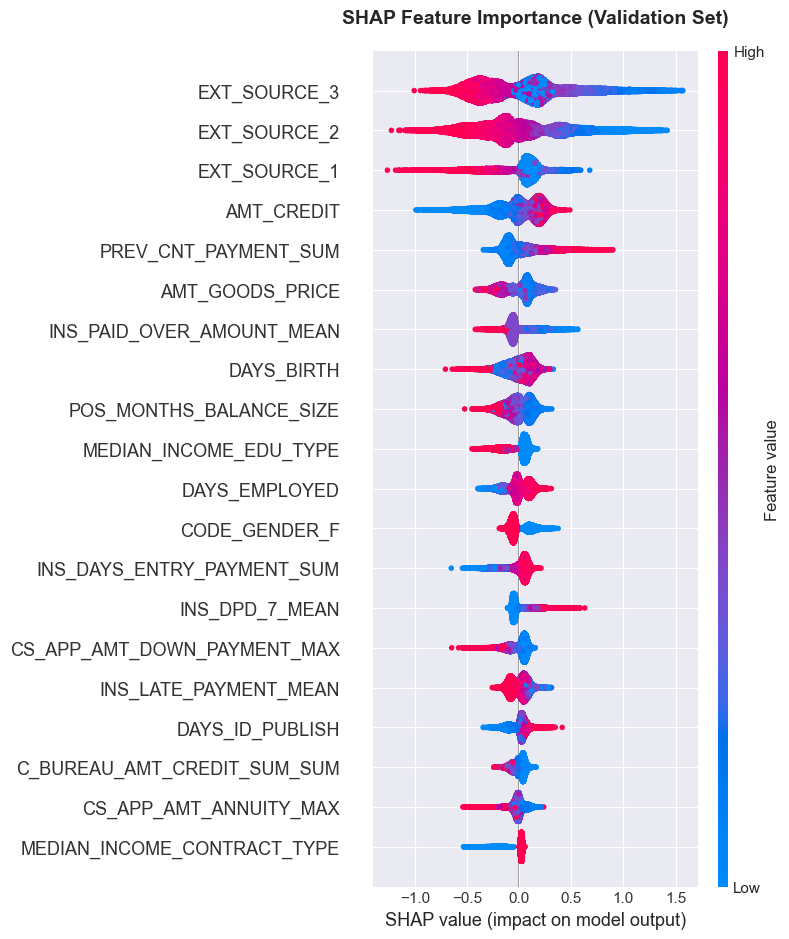

✓ SHAP summary plot saved as 'models/shap_summary_plot.png'

📊 Generating SHAP bar plot...


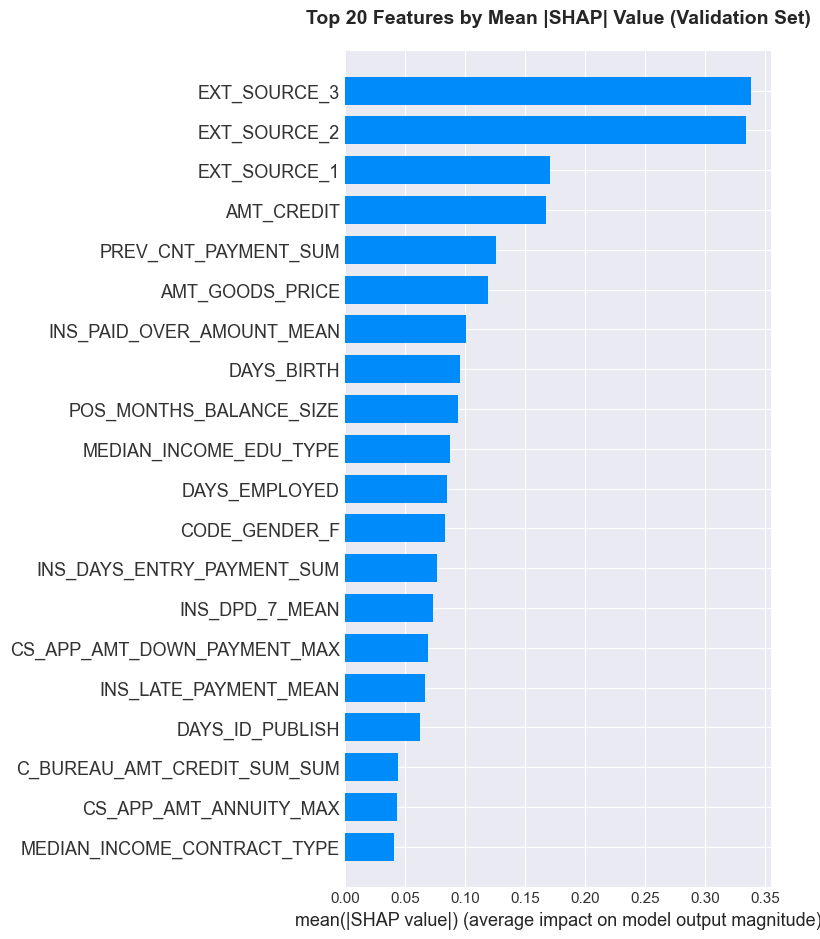

✓ SHAP bar plot saved as 'models/shap_bar_plot.png'

✅ SHAP analysis completed!


In [25]:
# ==========================================
# 8.2 FEATURE IMPORTANCE ANALYSIS WITH SHAP
# ==========================================
print("\n" + "="*80)
print("8.2 FEATURE IMPORTANCE ANALYSIS WITH SHAP")
print("="*80)

# Install shap if needed
try:
    import shap
    print("✓ SHAP library already installed")
except ImportError:
    print("⏳ Installing SHAP library...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap'])
    import shap
    print("✓ SHAP library installed successfully")

# Use validation set for SHAP analysis
print(f"\n⏳ Computing SHAP values on validation set...")
print(f"   Validation set size: {X_val_scaled.shape[0]:,} samples")

# Create SHAP explainer for tree-based model
explainer = shap.TreeExplainer(final_lgb_model)

# Calculate SHAP values on validation set
shap_values = explainer.shap_values(X_val_scaled)

# Handle different SHAP output formats
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # For binary classification, take class 1

print("✓ SHAP values computed successfully!")

# Calculate mean absolute SHAP values for feature importance
shap_importance = pd.DataFrame({
    'feature': selected_feature_names,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print(f"\n📊 Top 20 Most Important Features (by SHAP):")
print("="*80)
print(shap_importance.head(20).to_string(index=False))
print("="*80)

# Save SHAP importance
shap_importance.to_csv('models/shap_feature_importance.csv', index=False)
print("\n✓ SHAP feature importance saved to 'models/shap_feature_importance.csv'")

# Visualize SHAP summary plot
print("\n📊 Generating SHAP summary plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values, 
    X_val_scaled,
    feature_names=selected_feature_names,
    max_display=20,
    show=False
)
plt.title('SHAP Feature Importance (Validation Set)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('models/shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ SHAP summary plot saved as 'models/shap_summary_plot.png'")

# Visualize SHAP bar plot
print("\n📊 Generating SHAP bar plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values, 
    X_val_scaled,
    feature_names=selected_feature_names,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title('Top 20 Features by Mean |SHAP| Value (Validation Set)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('models/shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ SHAP bar plot saved as 'models/shap_bar_plot.png'")

print("\n✅ SHAP analysis completed!")

Giải thích predictions cụ thể cho 2 cases (default và no default) trên validation set


8.2.2 LOCAL EXPLANATION WITH LIME
✓ LIME library already installed

⏳ Creating prediction wrapper for scaled input...
✓ Prediction wrapper created

⏳ Creating LIME explainer with unscaled features...
✓ LIME explainer created (using unscaled features for interpretability)

CASE 1: DEFAULT CASE EXPLANATION (Validation Set)

📋 Sample Info:
  True Label:          Default (1)
  Predicted Prob:      0.8017 (in range 0.8-0.9)
  Predicted Class:     Default (1)

⏳ Generating LIME explanation for default case...

📊 Visualizing LIME explanation...


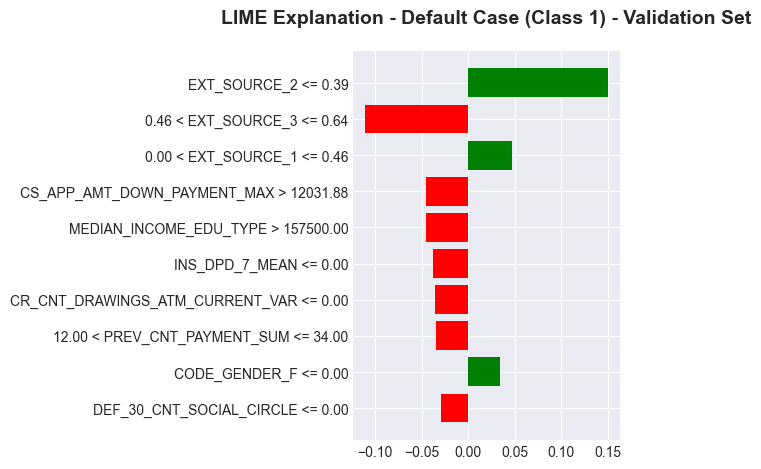

✓ LIME explanation saved as 'models/lime_explanation_default_val.png'

📈 Top 10 Features Influencing This Prediction:
  ↑ Increases default risk: EXT_SOURCE_2 <= 0.39 (weight: +0.1502)
  ↓ Decreases default risk: 0.46 < EXT_SOURCE_3 <= 0.64 (weight: -0.1103)
  ↑ Increases default risk: 0.00 < EXT_SOURCE_1 <= 0.46 (weight: +0.0475)
  ↓ Decreases default risk: CS_APP_AMT_DOWN_PAYMENT_MAX > 12031.88 (weight: -0.0454)
  ↓ Decreases default risk: MEDIAN_INCOME_EDU_TYPE > 157500.00 (weight: -0.0452)
  ↓ Decreases default risk: INS_DPD_7_MEAN <= 0.00 (weight: -0.0375)
  ↓ Decreases default risk: CR_CNT_DRAWINGS_ATM_CURRENT_VAR <= 0.00 (weight: -0.0355)
  ↓ Decreases default risk: 12.00 < PREV_CNT_PAYMENT_SUM <= 34.00 (weight: -0.0348)
  ↑ Increases default risk: CODE_GENDER_F <= 0.00 (weight: +0.0341)
  ↓ Decreases default risk: DEF_30_CNT_SOCIAL_CIRCLE <= 0.00 (weight: -0.0287)

CASE 2: NO DEFAULT CASE EXPLANATION (Validation Set)

📋 Sample Info:
  True Label:          No Default (0)
  Predi

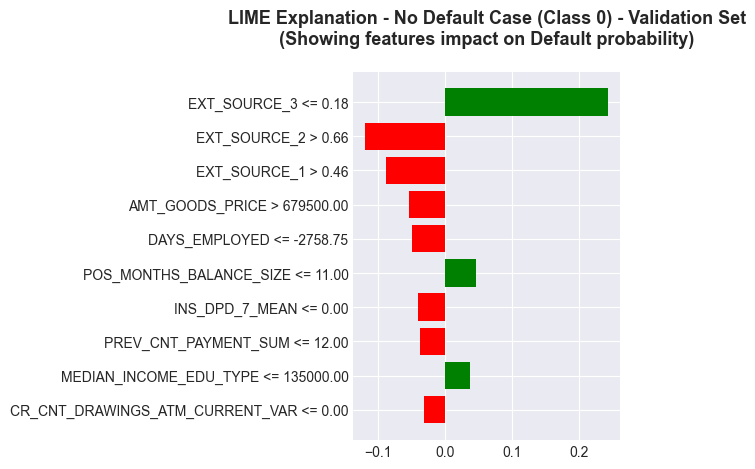

✓ LIME explanation saved as 'models/lime_explanation_no_default_val.png'

📈 Top 10 Features Influencing This Prediction:
   (Impact on Default probability - Class 1)
  ↑ Increases default risk: EXT_SOURCE_3 <= 0.18 (weight: +0.2436)
  ↓ Decreases default risk: EXT_SOURCE_2 > 0.66 (weight: -0.1193)
  ↓ Decreases default risk: EXT_SOURCE_1 > 0.46 (weight: -0.0891)
  ↓ Decreases default risk: AMT_GOODS_PRICE > 679500.00 (weight: -0.0546)
  ↓ Decreases default risk: DAYS_EMPLOYED <= -2758.75 (weight: -0.0497)
  ↑ Increases default risk: POS_MONTHS_BALANCE_SIZE <= 11.00 (weight: +0.0461)
  ↓ Decreases default risk: INS_DPD_7_MEAN <= 0.00 (weight: -0.0405)
  ↓ Decreases default risk: PREV_CNT_PAYMENT_SUM <= 12.00 (weight: -0.0383)
  ↑ Increases default risk: MEDIAN_INCOME_EDU_TYPE <= 135000.00 (weight: +0.0377)
  ↓ Decreases default risk: CR_CNT_DRAWINGS_ATM_CURRENT_VAR <= 0.00 (weight: -0.0317)

✅ LIME LOCAL EXPLANATION COMPLETED!


In [26]:
# ==========================================
# 8.2.2 LOCAL EXPLANATION WITH LIME
# ==========================================
print("\n" + "="*80)
print("8.2.2 LOCAL EXPLANATION WITH LIME")
print("="*80)

# Install lime if not available
try:
    import lime
    import lime.lime_tabular
    print("✓ LIME library already installed")
except ImportError:
    print("⏳ Installing LIME library...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'lime'])
    import lime
    import lime.lime_tabular
    print("✓ LIME library installed successfully")

# Create wrapper function to scale data before prediction
print("\n⏳ Creating prediction wrapper for scaled input...")
def predict_proba_with_scaling(X_unscaled):
    """
    Wrapper function that scales unscaled data before prediction.
    LIME will pass unscaled data, we scale it before feeding to model.
    """
    X_scaled = scaler.transform(X_unscaled)
    return final_lgb_model.predict_proba(X_scaled)
print("✓ Prediction wrapper created")

# Create LIME explainer with UNSCALED validation data
print("\n⏳ Creating LIME explainer with unscaled features...")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_val_selected.values,  # Use unscaled data
    feature_names=selected_feature_names,
    class_names=['No Default (0)', 'Default (1)'],
    mode='classification',
    random_state=RANDOM_STATE
)
print("✓ LIME explainer created (using unscaled features for interpretability)")

# ==========================================
# CASE 1: Explain a DEFAULT case (class 1)
# ==========================================
print("\n" + "="*80)
print("CASE 1: DEFAULT CASE EXPLANATION (Validation Set)")
print("="*80)

# Find a case with: true label = 1, prediction probability in range [0.8, 0.9]
default_indices = np.where(
    (y_val.values == 1) & 
    (y_val_pred_tuned >= 0.8) & 
    (y_val_pred_tuned <= 0.9)
)[0]

if len(default_indices) > 0:
    default_idx = default_indices[0]
    default_case = X_val_selected.iloc[default_idx].values  # Use unscaled case
    
    print(f"\n📋 Sample Info:")
    print(f"  True Label:          Default (1)")
    print(f"  Predicted Prob:      {y_val_pred_tuned[default_idx]:.4f} (in range 0.8-0.9)")
    print(f"  Predicted Class:     {'Default (1)' if y_val_pred_tuned[default_idx] >= 0.5 else 'No Default (0)'}")
    
    # Generate LIME explanation
    print("\n⏳ Generating LIME explanation for default case...")
    lime_exp_default = lime_explainer.explain_instance(
        default_case,
        predict_proba_with_scaling,  # Use wrapper function
        num_features=10,
        top_labels=1
    )
    
    # Visualize
    print("\n📊 Visualizing LIME explanation...")
    fig = lime_exp_default.as_pyplot_figure(label=1)
    plt.title('LIME Explanation - Default Case (Class 1) - Validation Set', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('models/lime_explanation_default_val.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ LIME explanation saved as 'models/lime_explanation_default_val.png'")
    
    # Print top features
    print("\n📈 Top 10 Features Influencing This Prediction:")
    for feature, weight in lime_exp_default.as_list(label=1)[:10]:
        direction = "↑ Increases" if weight > 0 else "↓ Decreases"
        print(f"  {direction} default risk: {feature} (weight: {weight:+.4f})")
else:
    print("\n⚠️ No default cases found with prediction probability in range [0.8, 0.9]")

# ==========================================
# CASE 2: Explain a NO DEFAULT case (class 0)
# ==========================================
print("\n" + "="*80)
print("CASE 2: NO DEFAULT CASE EXPLANATION (Validation Set)")
print("="*80)

# Find a case with: true label = 0, prediction probability in range [0.1, 0.2]
no_default_indices = np.where(
    (y_val.values == 0) & 
    (y_val_pred_tuned >= 0.1) & 
    (y_val_pred_tuned <= 0.2)
)[0]

if len(no_default_indices) > 0:
    no_default_idx = no_default_indices[0]
    no_default_case = X_val_selected.iloc[no_default_idx].values  # Use unscaled case
    
    print(f"\n📋 Sample Info:")
    print(f"  True Label:          No Default (0)")
    print(f"  Predicted Prob:      {y_val_pred_tuned[no_default_idx]:.4f} (in range 0.1-0.2)")
    print(f"  Predicted Class:     {'Default (1)' if y_val_pred_tuned[no_default_idx] >= 0.5 else 'No Default (0)'}")
    
    # Generate LIME explanation
    print("\n⏳ Generating LIME explanation for no default case...")
    lime_exp_no_default = lime_explainer.explain_instance(
        no_default_case,
        predict_proba_with_scaling,  # Use wrapper function
        num_features=10,
        top_labels=2  # Get both labels
    )
    
    # Visualize - for No Default case, show explanation for class 0
    print("\n📊 Visualizing LIME explanation...")
    # Try to get the label that was actually predicted
    predicted_label = 1 if y_val_pred_tuned[no_default_idx] >= 0.5 else 0
    
    # For visualization, always show label 1 (default risk) to maintain consistency
    # But we'll show how features push probability towards/away from default
    try:
        fig = lime_exp_no_default.as_pyplot_figure(label=1)
        plt.title('LIME Explanation - No Default Case (Class 0) - Validation Set\n(Showing features impact on Default probability)', 
                  fontsize=13, fontweight='bold', pad=20)
    except KeyError:
        # If label 1 doesn't exist, use label 0
        fig = lime_exp_no_default.as_pyplot_figure(label=0)
        plt.title('LIME Explanation - No Default Case (Class 0) - Validation Set\n(Showing features impact on No Default probability)', 
                  fontsize=13, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig('models/lime_explanation_no_default_val.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ LIME explanation saved as 'models/lime_explanation_no_default_val.png'")
    
    # Print top features for both interpretations
    print("\n📈 Top 10 Features Influencing This Prediction:")
    try:
        # Try to get explanation for default class (label 1)
        features_list = lime_exp_no_default.as_list(label=1)[:10]
        print("   (Impact on Default probability - Class 1)")
        for feature, weight in features_list:
            direction = "↑ Increases" if weight > 0 else "↓ Decreases"
            print(f"  {direction} default risk: {feature} (weight: {weight:+.4f})")
    except KeyError:
        # If not available, show for no-default class (label 0)
        features_list = lime_exp_no_default.as_list(label=0)[:10]
        print("   (Impact on No Default probability - Class 0)")
        for feature, weight in features_list:
            direction = "↑ Increases" if weight > 0 else "↓ Decreases"
            print(f"  {direction} no-default probability: {feature} (weight: {weight:+.4f})")
else:
    print("\n⚠️ No no-default cases found with prediction probability in range [0.1, 0.2]")

print("\n" + "="*80)
print("✅ LIME LOCAL EXPLANATION COMPLETED!")
print("="*80)


PREDICTION PROBABILITY DISTRIBUTION ON VALIDATION SET


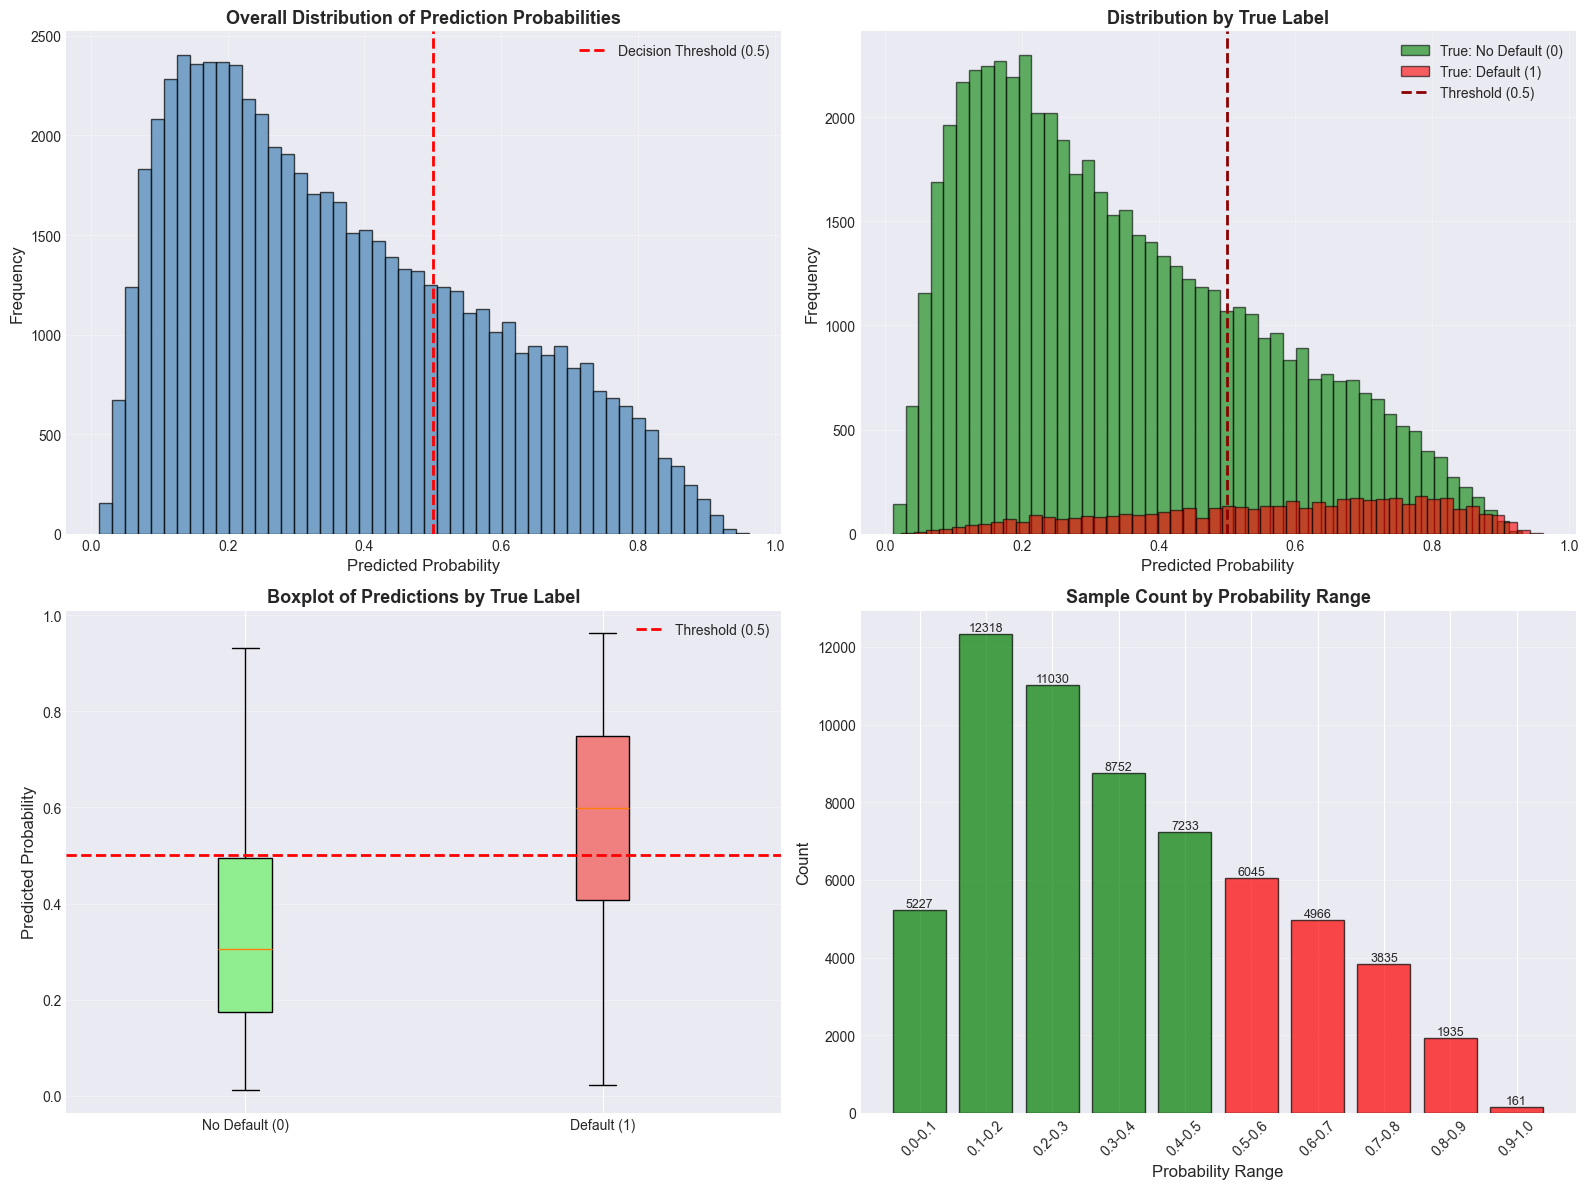


📊 Prediction Probability Statistics:
  Mean:                0.3647
  Median:              0.3230
  Std Dev:             0.2176
  Min:                 0.0117
  Max:                 0.9622

📋 Statistics by True Label:

  No Default (0):
    Mean Pred Prob:    0.3467
    Median Pred Prob:  0.3044
    Std Dev:           0.2083

  Default (1):
    Mean Pred Prob:    0.5688
    Median Pred Prob:  0.5991
    Std Dev:           0.2171

📊 Sample Counts by Probability Range:
Range           Count      Percentage   Class 0    Class 1   
------------------------------------------------------------
0.0-0.1         5227         8.50%       5170       57        
0.1-0.2         12318       20.03%       12062      256       
0.2-0.3         11030       17.93%       10615      415       
0.3-0.4         8752        14.23%       8268       484       
0.4-0.5         7233        11.76%       6640       593       
0.5-0.6         6045         9.83%       5357       688       
0.6-0.7         4966        

In [27]:
# ==========================================
# PREDICTION PROBABILITY DISTRIBUTION ON VALIDATION SET
# ==========================================
print("\n" + "="*80)
print("PREDICTION PROBABILITY DISTRIBUTION ON VALIDATION SET")
print("="*80)

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall Histogram
ax1 = axes[0, 0]
ax1.hist(y_val_pred_tuned, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
ax1.set_xlabel('Predicted Probability', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Overall Distribution of Prediction Probabilities', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Distribution by True Label
ax2 = axes[0, 1]
ax2.hist(y_val_pred_tuned[y_val == 0], bins=50, alpha=0.6, label='True: No Default (0)', color='green', edgecolor='black')
ax2.hist(y_val_pred_tuned[y_val == 1], bins=50, alpha=0.6, label='True: Default (1)', color='red', edgecolor='black')
ax2.axvline(x=0.5, color='darkred', linestyle='--', linewidth=2, label='Threshold (0.5)')
ax2.set_xlabel('Predicted Probability', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution by True Label', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Boxplot by True Label
ax3 = axes[1, 0]
box_data = [y_val_pred_tuned[y_val == 0], y_val_pred_tuned[y_val == 1]]
bp = ax3.boxplot(box_data, labels=['No Default (0)', 'Default (1)'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax3.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
ax3.set_ylabel('Predicted Probability', fontsize=12)
ax3.set_title('Boxplot of Predictions by True Label', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Probability Ranges Summary
ax4 = axes[1, 1]
ranges = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', 
          '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
counts = []
for i in range(10):
    lower = i * 0.1
    upper = (i + 1) * 0.1
    count = np.sum((y_val_pred_tuned >= lower) & (y_val_pred_tuned < upper))
    counts.append(count)

# Handle the last bin edge (1.0)
counts[-1] = np.sum((y_val_pred_tuned >= 0.9) & (y_val_pred_tuned <= 1.0))

colors_bar = ['green' if i < 5 else 'red' for i in range(10)]
bars = ax4.bar(ranges, counts, color=colors_bar, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Probability Range', fontsize=12)
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('Sample Count by Probability Range', fontsize=13, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('models/prediction_probability_distribution_val.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\n📊 Prediction Probability Statistics:")
print(f"  Mean:                {np.mean(y_val_pred_tuned):.4f}")
print(f"  Median:              {np.median(y_val_pred_tuned):.4f}")
print(f"  Std Dev:             {np.std(y_val_pred_tuned):.4f}")
print(f"  Min:                 {np.min(y_val_pred_tuned):.4f}")
print(f"  Max:                 {np.max(y_val_pred_tuned):.4f}")

print("\n📋 Statistics by True Label:")
print(f"\n  No Default (0):")
print(f"    Mean Pred Prob:    {np.mean(y_val_pred_tuned[y_val == 0]):.4f}")
print(f"    Median Pred Prob:  {np.median(y_val_pred_tuned[y_val == 0]):.4f}")
print(f"    Std Dev:           {np.std(y_val_pred_tuned[y_val == 0]):.4f}")

print(f"\n  Default (1):")
print(f"    Mean Pred Prob:    {np.mean(y_val_pred_tuned[y_val == 1]):.4f}")
print(f"    Median Pred Prob:  {np.median(y_val_pred_tuned[y_val == 1]):.4f}")
print(f"    Std Dev:           {np.std(y_val_pred_tuned[y_val == 1]):.4f}")

print("\n📊 Sample Counts by Probability Range:")
print(f"{'Range':<15} {'Count':<10} {'Percentage':<12} {'Class 0':<10} {'Class 1':<10}")
print("-" * 60)
for i, (range_name, count) in enumerate(zip(ranges, counts)):
    lower = i * 0.1
    upper = (i + 1) * 0.1 if i < 9 else 1.01
    
    # Count by class
    mask = (y_val_pred_tuned >= lower) & (y_val_pred_tuned < upper)
    count_class0 = np.sum(mask & (y_val.values == 0))
    count_class1 = np.sum(mask & (y_val.values == 1))
    
    pct = (count / len(y_val_pred_tuned)) * 100
    print(f"{range_name:<15} {count:<10} {pct:>6.2f}%       {count_class0:<10} {count_class1:<10}")

print("\n✓ Visualization saved as 'models/prediction_probability_distribution_val.png'")
print("="*80)

### 8.3 Model Calibration

Calibrate model với Isotonic Regression sử dụng validation set để cải thiện chất lượng dự đoán xác suất

In [28]:
# ==========================================
# 8.3 Model Calibration với Isotonic Regression
# ==========================================
print("\n" + "="*80)
print("8.3 MODEL CALIBRATION")
print("="*80)

print("\n🔧 Calibrating model với Isotonic Regression...")

# Import libraries
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

# Lấy predictions từ model tuned trên validation set (đã có từ bước trước)
# y_val_pred_tuned = final_lgb_model.predict_proba(X_val_scaled)[:, 1]

# Fit isotonic regression trên validation set
iso_reg = IsotonicRegression(out_of_bounds='clip')
iso_reg.fit(y_val_pred_tuned, y_val)

print("✓ Isotonic regression fitted on validation set")

# Tạo hàm dự đoán đã calibrated
def calibrated_predict_proba(X):
    """Dự đoán xác suất đã được calibrated"""
    raw_pred = final_lgb_model.predict_proba(X)
    calibrated_pred = raw_pred.copy()
    calibrated_pred[:, 1] = iso_reg.predict(raw_pred[:, 1])
    calibrated_pred[:, 0] = 1 - calibrated_pred[:, 1]
    return calibrated_pred

# Đánh giá sự khác biệt trên validation set
y_val_pred_calibrated = calibrated_predict_proba(X_val_scaled)[:, 1]

# So sánh Brier Score
brier_before = brier_score_loss(y_val, y_val_pred_tuned)
brier_after = brier_score_loss(y_val, y_val_pred_calibrated)

print("\n📊 Calibration Results on Validation Set:")
print(f"   Brier Score Before: {brier_before:.6f}")
print(f"   Brier Score After:  {brier_after:.6f}")
print(f"   Improvement: {(brier_before - brier_after):.6f} ({(brier_before - brier_after) / brier_before * 100:.2f}%)")

# So sánh các metrics khác
from sklearn.metrics import roc_auc_score, average_precision_score

roc_before = roc_auc_score(y_val, y_val_pred_tuned)
roc_after = roc_auc_score(y_val, y_val_pred_calibrated)

pr_before = average_precision_score(y_val, y_val_pred_tuned)
pr_after = average_precision_score(y_val, y_val_pred_calibrated)

print(f"\n📈 Other Metrics Comparison on Validation Set:")
print(f"   ROC AUC - Before: {roc_before:.6f}, After: {roc_after:.6f}")
print(f"   PR AUC  - Before: {pr_before:.6f}, After: {pr_after:.6f}")

# Lưu calibrator
joblib.dump(iso_reg, 'models/isotonic_calibrator.pkl')
print("\n✅ Isotonic calibrator saved to models/isotonic_calibrator.pkl")


8.3 MODEL CALIBRATION

🔧 Calibrating model với Isotonic Regression...
✓ Isotonic regression fitted on validation set

📊 Calibration Results on Validation Set:
   Brier Score Before: 0.169214
   Brier Score After:  0.067022
   Improvement: 0.102193 (60.39%)

📈 Other Metrics Comparison on Validation Set:
   ROC AUC - Before: 0.767135, After: 0.768547
   PR AUC  - Before: 0.259409, After: 0.252281

✅ Isotonic calibrator saved to models/isotonic_calibrator.pkl


### 8.4 Visualize Calibration Results


📊 Visualizing calibration curves...


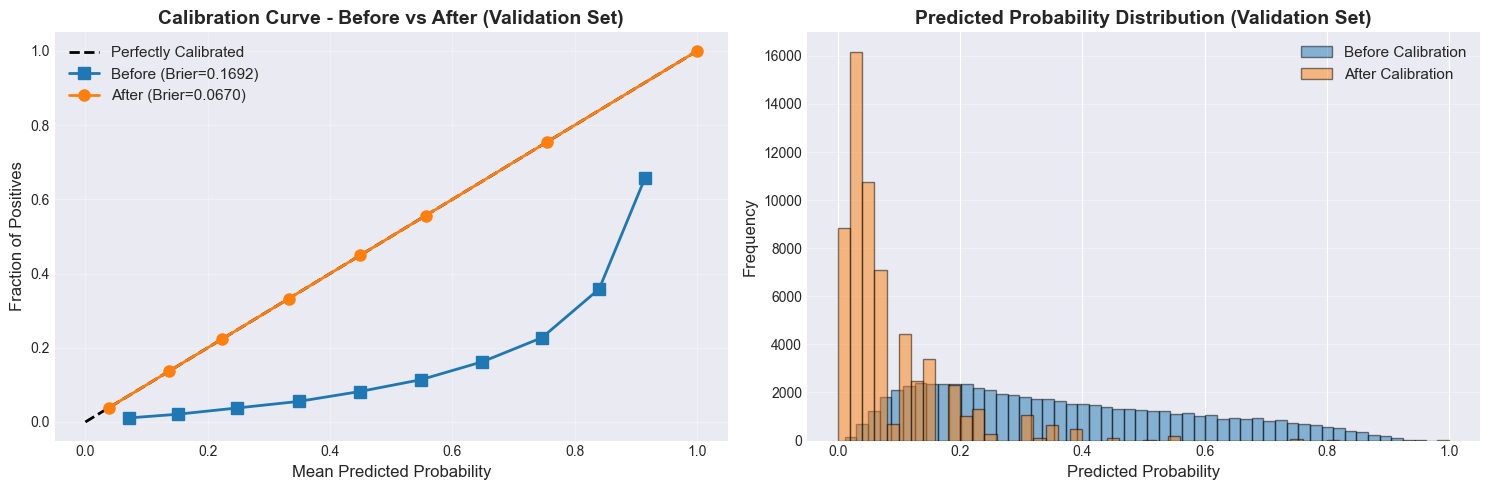

✅ Calibration visualization saved as 'models/calibration_visualization.png'

✅ SECTION 8 COMPLETED - Model trained, analyzed, and calibrated!


In [29]:
# ==========================================
# 8.4 VISUALIZE CALIBRATION RESULTS
# ==========================================
print("\n📊 Visualizing calibration curves...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Calibration Curve
prob_true_before, prob_pred_before = calibration_curve(y_val, y_val_pred_tuned, n_bins=10)
prob_true_after, prob_pred_after = calibration_curve(y_val, y_val_pred_calibrated, n_bins=10)

axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated', linewidth=2)
axes[0].plot(prob_pred_before, prob_true_before, 's-', label=f'Before (Brier={brier_before:.4f})', linewidth=2, markersize=8)
axes[0].plot(prob_pred_after, prob_true_after, 'o-', label=f'After (Brier={brier_after:.4f})', linewidth=2, markersize=8)
axes[0].set_xlabel('Mean Predicted Probability', fontsize=12)
axes[0].set_ylabel('Fraction of Positives', fontsize=12)
axes[0].set_title('Calibration Curve - Before vs After (Validation Set)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Probability Distribution
axes[1].hist(y_val_pred_tuned, bins=50, alpha=0.5, label='Before Calibration', edgecolor='black')
axes[1].hist(y_val_pred_calibrated, bins=50, alpha=0.5, label='After Calibration', edgecolor='black')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Predicted Probability Distribution (Validation Set)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('models/calibration_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Calibration visualization saved as 'models/calibration_visualization.png'")
print("\n" + "="*80)
print("✅ SECTION 8 COMPLETED - Model trained, analyzed, and calibrated!")
print("="*80)

## 9. Final Model Evaluation on Test Set

Đánh giá model LightGBM đã tune và calibrate trên test set để có kết quả cuối cùng

In [30]:
# ==========================================
# 9. FINAL EVALUATION ON TEST SET
# ==========================================

print("\n" + "="*80)
print("9. FINAL MODEL EVALUATION ON TEST SET")
print("="*80)

# Predictions on test set with calibrated model
print("\n⏳ Generating calibrated predictions on test set...")
y_test_pred_final = calibrated_predict_proba(X_test_scaled)[:, 1]

# Evaluate on test set
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    f1_score, 
    precision_score, 
    recall_score, 
    accuracy_score,
    brier_score_loss,
    classification_report,
    confusion_matrix
)

# Calculate metrics
test_roc_auc = roc_auc_score(y_test, y_test_pred_final)
test_pr_auc = average_precision_score(y_test, y_test_pred_final)
test_brier = brier_score_loss(y_test, y_test_pred_final)

# Classification metrics with optimal threshold
y_test_pred_class = (y_test_pred_final >= 0.5).astype(int)
test_f1 = f1_score(y_test, y_test_pred_class)
test_precision = precision_score(y_test, y_test_pred_class)
test_recall = recall_score(y_test, y_test_pred_class)
test_accuracy = accuracy_score(y_test, y_test_pred_class)

print("\n" + "="*80)
print("📊 FINAL TEST SET RESULTS")
print("="*80)
print(f"\n🎯 Probability Metrics:")
print(f"   ROC AUC:        {test_roc_auc:.4f}")
print(f"   PR AUC:         {test_pr_auc:.4f}")
print(f"   Brier Score:    {test_brier:.6f}")

print(f"\n🎯 Classification Metrics (threshold=0.5):")
print(f"   Accuracy:       {test_accuracy:.4f}")
print(f"   Precision:      {test_precision:.4f}")
print(f"   Recall:         {test_recall:.4f}")
print(f"   F1 Score:       {test_f1:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_test_pred_class, target_names=['No Default', 'Default']))

print("\n📋 Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred_class)
print(cm)
print(f"\n   True Negatives:  {cm[0,0]:,}")
print(f"   False Positives: {cm[0,1]:,}")
print(f"   False Negatives: {cm[1,0]:,}")
print(f"   True Positives:  {cm[1,1]:,}")

# Save final results
final_test_results = {
    'model': 'LightGBM (Tuned & Calibrated)',
    'roc_auc': test_roc_auc,
    'pr_auc': test_pr_auc,
    'brier': test_brier,
    'accuracy': test_accuracy,
    'precision': test_precision,
    'recall': test_recall,
    'f1': test_f1
}

import json
with open('models/final_test_results.json', 'w') as f:
    json.dump(final_test_results, f, indent=2)

print("\n✅ Final test results saved to 'models/final_test_results.json'")
print("="*80)


9. FINAL MODEL EVALUATION ON TEST SET

⏳ Generating calibrated predictions on test set...



📊 FINAL TEST SET RESULTS

🎯 Probability Metrics:
   ROC AUC:        0.7691
   PR AUC:         0.2497
   Brier Score:    0.066955

🎯 Classification Metrics (threshold=0.5):
   Accuracy:       0.9203
   Precision:      0.5751
   Recall:         0.0364
   F1 Score:       0.0684

📋 Classification Report:
              precision    recall  f1-score   support

  No Default       0.92      1.00      0.96     56554
     Default       0.58      0.04      0.07      4949

    accuracy                           0.92     61503
   macro avg       0.75      0.52      0.51     61503
weighted avg       0.89      0.92      0.89     61503


📋 Confusion Matrix:
[[56421   133]
 [ 4769   180]]

   True Negatives:  56,421
   False Positives: 133
   False Negatives: 4,769
   True Positives:  180

✅ Final test results saved to 'models/final_test_results.json'



📊 Visualizing final test set performance...



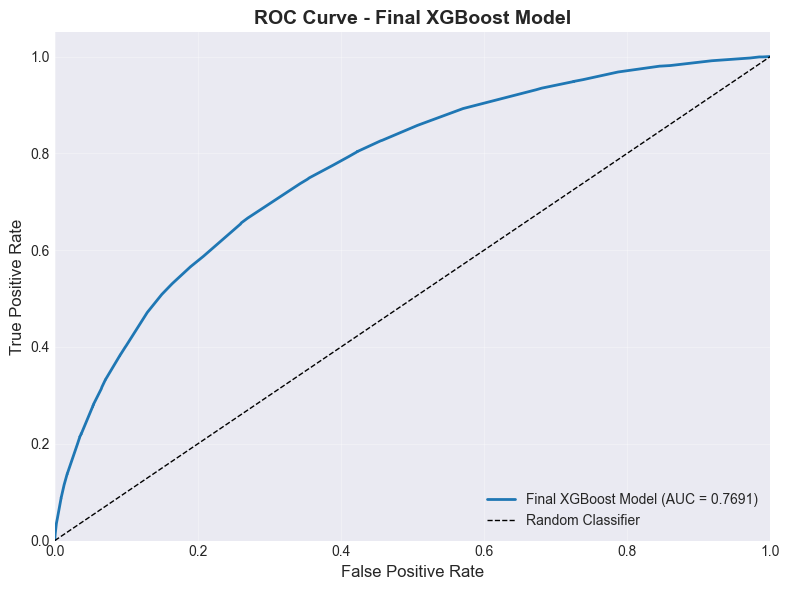

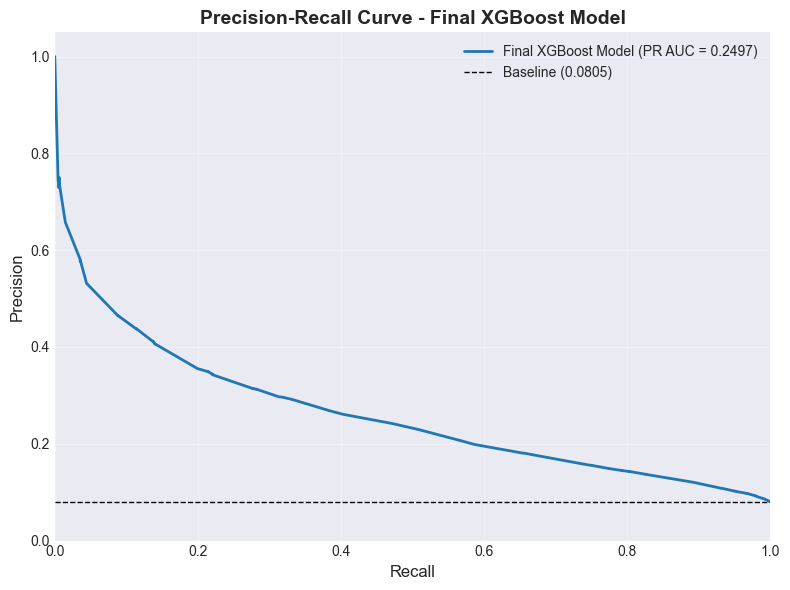

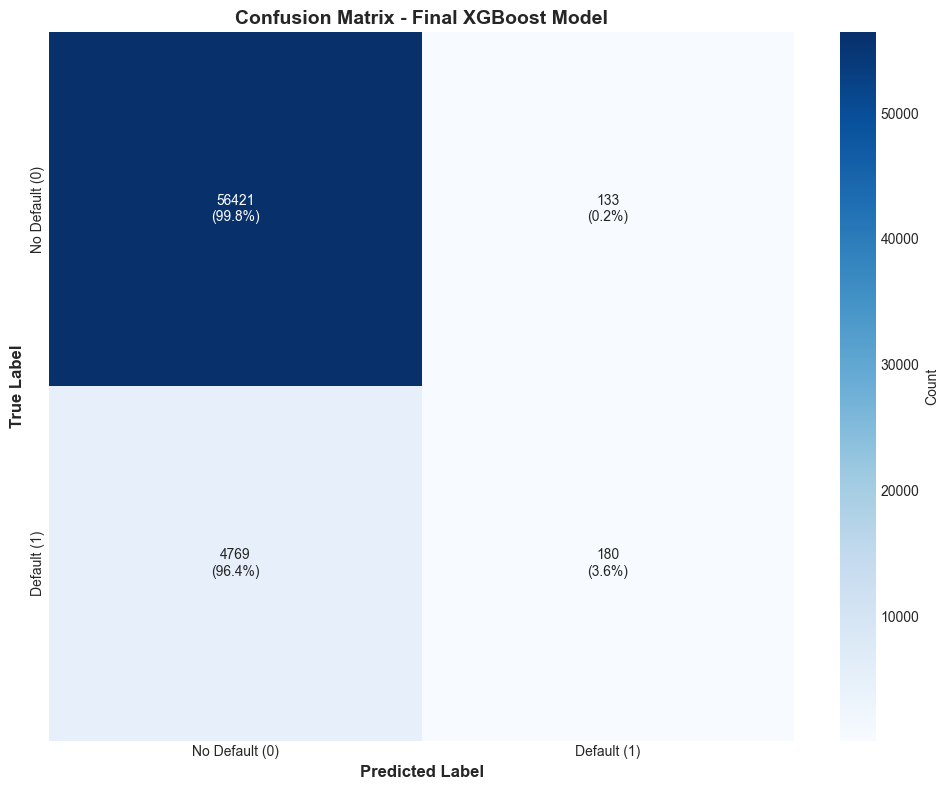


Confusion Matrix Details:
True Negatives:    56421 (91.74%)
False Positives:     133 ( 0.22%)
False Negatives:    4769 ( 7.75%)
True Positives:      180 ( 0.29%)


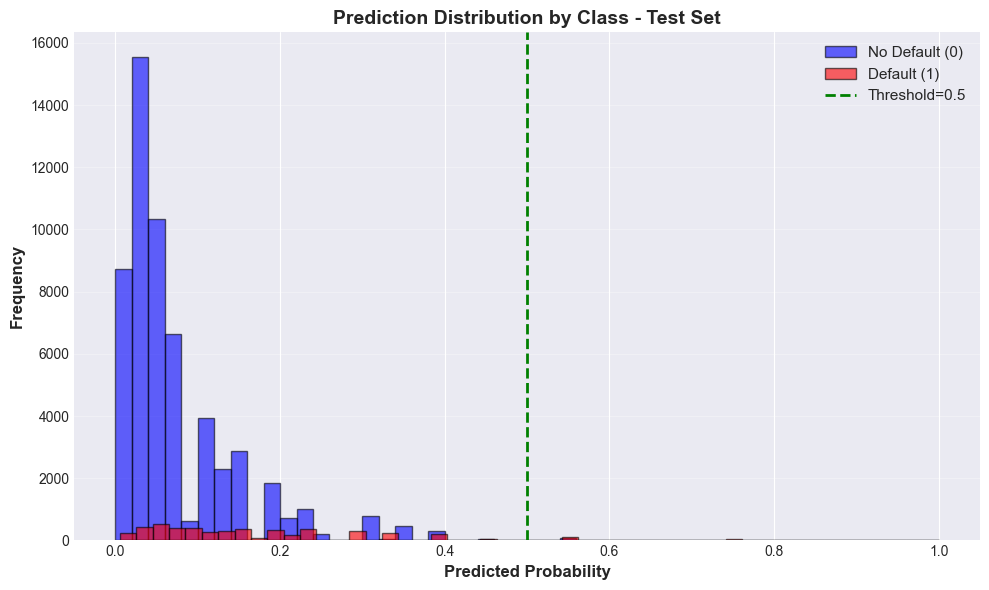


🎉 MODEL TRAINING AND EVALUATION COMPLETED!


In [31]:
# ==========================================
# VISUALIZE FINAL TEST RESULTS
# ==========================================
print("\n📊 Visualizing final test set performance...\n")

# Use shared plotting functions from model_utils
from src.model_utils import plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

# Plot ROC Curve
plot_roc_curve(y_test, y_test_pred_final, model_name="Final XGBoost Model")

# Plot Precision-Recall Curve
plot_precision_recall_curve(y_test, y_test_pred_final, model_name="Final XGBoost Model")

# Plot Confusion Matrix
y_test_pred_class = (y_test_pred_final >= 0.5).astype(int)
plot_confusion_matrix(y_test, y_test_pred_class, model_name="Final XGBoost Model")

# Additional plot: Prediction Distribution by Class
plt.figure(figsize=(10, 6))
plt.hist(y_test_pred_final[y_test == 0], bins=50, alpha=0.6, label='No Default (0)', color='blue', edgecolor='black')
plt.hist(y_test_pred_final[y_test == 1], bins=50, alpha=0.6, label='Default (1)', color='red', edgecolor='black')
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Threshold=0.5')
plt.xlabel('Predicted Probability', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Prediction Distribution by Class - Test Set', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("🎉 MODEL TRAINING AND EVALUATION COMPLETED!")
print("="*80)

## 10. Summary & Conclusion

### Quy trình Training đã thực hiện:

1. **Baseline Models**: Train trên train set (60%), evaluate trên val set (20%)
   - Logistic Regression
   - Random Forest  
   - XGBoost
   - LightGBM

2. **Hyperparameter Tuning**: 
   - Train trên train set (60%)
   - Tune trên val set (20%) - không sử dụng cross-validation
   - Tối ưu hóa PR AUC

3. **Final Model**:
   - Train LightGBM với best hyperparameters trên train+val (80%)
   - Calibrate với Isotonic Regression
   - Evaluate trên test set (20%)

### Kết quả cuối cùng:
Model LightGBM đã được tune và calibrate, đánh giá trên test set với các metrics được lưu trong `models/final_test_results.json`